# **Predicting Oral Temperature and Fever Detection using Infrared Thermography Data**

#### **Hygen Amoniku**

<br>

<br>


### Overview
This notebook, structured as an end-to-end ML case study, develops and evaluates machine-learning models to predict oral temperature from infrared thermography data and to detect fever using clinically relevant thresholds. The workflow integrates data preprocessing, feature engineering, model training, cross-validation, and final held-out test evaluation.


Two prediction tasks are addressed:

1. **Regression** – estimating continuous oral temperature in:
   - fast-mode (`aveOralF`)
   - monitor-mode (`aveOralM`)
2. **Classification** – detecting fever based on:
   - `feverF` (derived from `aveOralF`)
   - `feverM` (derived from `aveOralM`)

The dataset comes from the UCI Machine Learning Repository and includes 33 features such as demographic information, environmental conditions, and multiple infrared measurements taken across facial regions.

This notebook will follow an end-to-end ML pipeline including data exploration, preprocessing, model building, evaluation, and tuning. Preprocessing includes categorical encoding, scaling, and the construction of an ordinal feature for age. Due to label imbalance, a **stratified train–test split** is used, followed by:
- **k-fold cross-validation** for regression model selection  
- a **separate validation set** for classification threshold tuning and model comparison  

Multiple model families are evaluated, including linear regressors, regularised models (Ridge, Lasso, Elastic Net), polynomial regression, k-NN, neural networks (MLP), logistic regression, SGD, and Random Forest.

Final model performance is reported only once on the **unseen test set**, after all tuning and selection steps, to avoid data leakage. The workflow concludes with model interpretation using permutation importance and feature importance analyses.

<br>

---

<br>

### Environment Setup
Importing the necessary libraries. This includes standard data science libraries as well as specific modules from scikit-learn for modelling.


In [1]:
# Ensure Python 3.5+ is installed
import sys
assert sys.version_info >= (3, 5)

# Import core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

# Reproducibility
SEED = 42

# Make Python, NumPy and hashing deterministic
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Matplotlib configuration for inline plotting
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Set a project root and images path (for saving plots)
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "infrared_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# Function to save figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings; warnings.filterwarnings("ignore")

### **Data Import**

We are using the Infrared Thermography Temperature Dataset available from the UCI Machine Learning Repository. First, we need to install and import the `ucimlrepo` package to fetch the data.


In [2]:
!pip install -q ucimlrepo
from ucimlrepo import fetch_ucirepo

# Fetch the dataset using its UCI id (925)
infrared_data = fetch_ucirepo(id=925)

# Extract features and targets
X = infrared_data.data.features
y = infrared_data.data.targets

# Print dataset metadata information
print("Dataset Name:", infrared_data.metadata.get('name'))
print("Number of Instances:", infrared_data.metadata.get('num_instances'))
print("Number of Features:", infrared_data.metadata.get('num_features'))
print("Target Columns:", infrared_data.metadata.get('target_col'))


# Display variables table
print("\nVariable Information:")
display(infrared_data.variables.dropna(axis=1, how='all').style.set_table_styles(
    [{'selector': 'th, td', 'props': [('text-align', 'left')]}]
))

Dataset Name: Infrared Thermography Temperature
Number of Instances: 1020
Number of Features: 33
Target Columns: ['aveOralF', 'aveOralM']

Variable Information:


### **Exploratory Data Analysis**

Exploring the dataset to understand its structure, check for missing values, and visualise the distributions of key features.


In [3]:
# Inspect the first few rows of features and targets

print("\nFeatures:")
display(X.head())

print("\nTarget Variables:")
display(y.head())

print("\nFeatures Description:")
display(X.describe())

print("\nMissing values in the set:")
X.isnull().sum()



Features:


Gender    Age                  Ethnicity  T_atm  Humidity  Distance  \
0    Male  41-50                      White   24.0      28.0       0.8   
1  Female  31-40  Black or African-American   24.0      26.0       0.8   
2  Female  21-30                      White   24.0      26.0       0.8   
3  Female  21-30  Black or African-American   24.0      27.0       0.8   
4    Male  18-20                      White   24.0      27.0       0.8   

   T_offset1  Max1R13_1  Max1L13_1  aveAllR13_1  ...  T_FHCC1  T_FHRC1  \
0     0.7025    35.0300    35.3775      34.4000  ...  33.5775  33.4775   
1     0.7800    34.5500    34.5200      33.9300  ...  34.0325  34.0550   
2     0.8625    35.6525    35.5175      34.2775  ...  34.9000  34.8275   
3     0.9300    35.2225    35.6125      34.3850  ...  34.4400  34.4225   
4     0.8950    35.5450    35.6650      34.9100  ...  35.0900  35.1600   

   T_FHLC1  T_FHBC1  T_FHTC1  T_FH_Max1  T_FHC_Max1   T_Max1    T_OR1  \
0  33.3725  33.4925  33.0025    34.5300     34.0075  35.6925  35.6350   
1  33.6775  33.9700  34.0025    34.6825     34.6600  35.1750  35.0925   
2  34.6475  34.8200  34.6700    35.3450     35.2225  35.9125  35.8600   
3  34.6550  34.3025  34.9175    35.6025     35.3150  35.7200  34.9650   
4  34.3975  34.6700  33.8275    35.4175     35.3725  35.8950  35.5875   

   T_OR_Max1  
0    35.6525  
1    35.1075  
2    35.8850  
3    34.9825  
4    35.6175  

[5 rows x 33 columns]


Target Variables:


aveOralF  aveOralM
0     36.85     36.59
1     37.00     37.19
2     37.20     37.34
3     36.85     37.09
4     36.80     37.04


Features Description:


T_atm     Humidity     Distance    T_offset1    Max1R13_1  \
count  1020.000000  1020.000000  1018.000000  1020.000000  1020.000000   
mean     24.115392    28.723039     0.729784     0.968648    35.596533   
std       1.336338    13.071627     2.456486     0.362587     0.574888   
min      20.200000     9.900000     0.540000    -0.590000    33.897500   
25%      23.400000    17.600000     0.600000     0.772500    35.247500   
50%      24.000000    26.300000     0.620000     0.940000    35.548750   
75%      24.700000    36.200000     0.700000     1.140000    35.872500   
max      29.100000    61.200000    79.000000     2.875000    38.405000   

         Max1L13_1  aveAllR13_1  aveAllL13_1        T_RC1    T_RC_Dry1  ...  \
count  1020.000000  1020.000000  1020.000000  1020.000000  1020.000000  ...   
mean     35.611474    34.888475    35.011345    35.659921    35.587143  ...   
std       0.549760     0.718613     0.633836     0.553897     0.569278  ...   
min      34.122500    31.770000    32.902500    33.985000    33.825000  ...   
25%      35.271875    34.456250    34.651250    35.332500    35.249375  ...   
50%      35.575000    34.915000    34.997500    35.602500    35.533750  ...   
75%      35.883125    35.300000    35.363125    35.910625    35.855625  ...   
max      38.042500    37.575000    37.680000    38.385000    38.380000  ...   

           T_FHCC1      T_FHRC1      T_FHLC1      T_FHBC1      T_FHTC1  \
count  1020.000000  1020.000000  1020.000000  1020.000000  1020.000000   
mean     34.573865    34.567782    34.565340    34.487701    34.577293   
std       0.672461     0.669410     0.678663     0.668065     0.728678   
min      31.050000    31.452500    31.657500    31.280000    31.150000   
25%      34.213125    34.180000    34.177500    34.096875    34.225000   
50%      34.605000    34.597500    34.602500    34.512917    34.622500   
75%      34.965625    34.968125    34.965000    34.878125    35.012500   
max      37.125000    37.075000    37.165000    37.212500    37.367500   

         T_FH_Max1   T_FHC_Max1       T_Max1        T_OR1    T_OR_Max1  
count  1020.000000  1020.000000  1020.000000  1020.000000  1020.000000  
mean     35.421555    35.094144    36.084785    35.805519    35.838277  
std       0.523477     0.576045     0.491821     0.559258     0.559316  
min      33.407500    32.440000    34.892500    33.802500    33.835000  
25%      35.116875    34.756458    35.775000    35.474375    35.500000  
50%      35.391250    35.100000    36.027500    35.790000    35.825000  
75%      35.675000    35.415000    36.280000    36.087500    36.120625  
max      38.002500    37.632500    38.807500    38.417500    38.455000  

[8 rows x 30 columns]


Missing values in the set:


Gender         0
Age            0
Ethnicity      0
T_atm          0
Humidity       0
Distance       2
T_offset1      0
Max1R13_1      0
Max1L13_1      0
aveAllR13_1    0
aveAllL13_1    0
T_RC1          0
T_RC_Dry1      0
T_RC_Wet1      0
T_RC_Max1      0
T_LC1          0
T_LC_Dry1      0
T_LC_Wet1      0
T_LC_Max1      0
RCC1           0
LCC1           0
canthiMax1     0
canthi4Max1    0
T_FHCC1        0
T_FHRC1        0
T_FHLC1        0
T_FHBC1        0
T_FHTC1        0
T_FH_Max1      0
T_FHC_Max1     0
T_Max1         0
T_OR1          0
T_OR_Max1      0
dtype: int64

- Noted two missing values on `Distance` feature.

Saving figure features_histogram


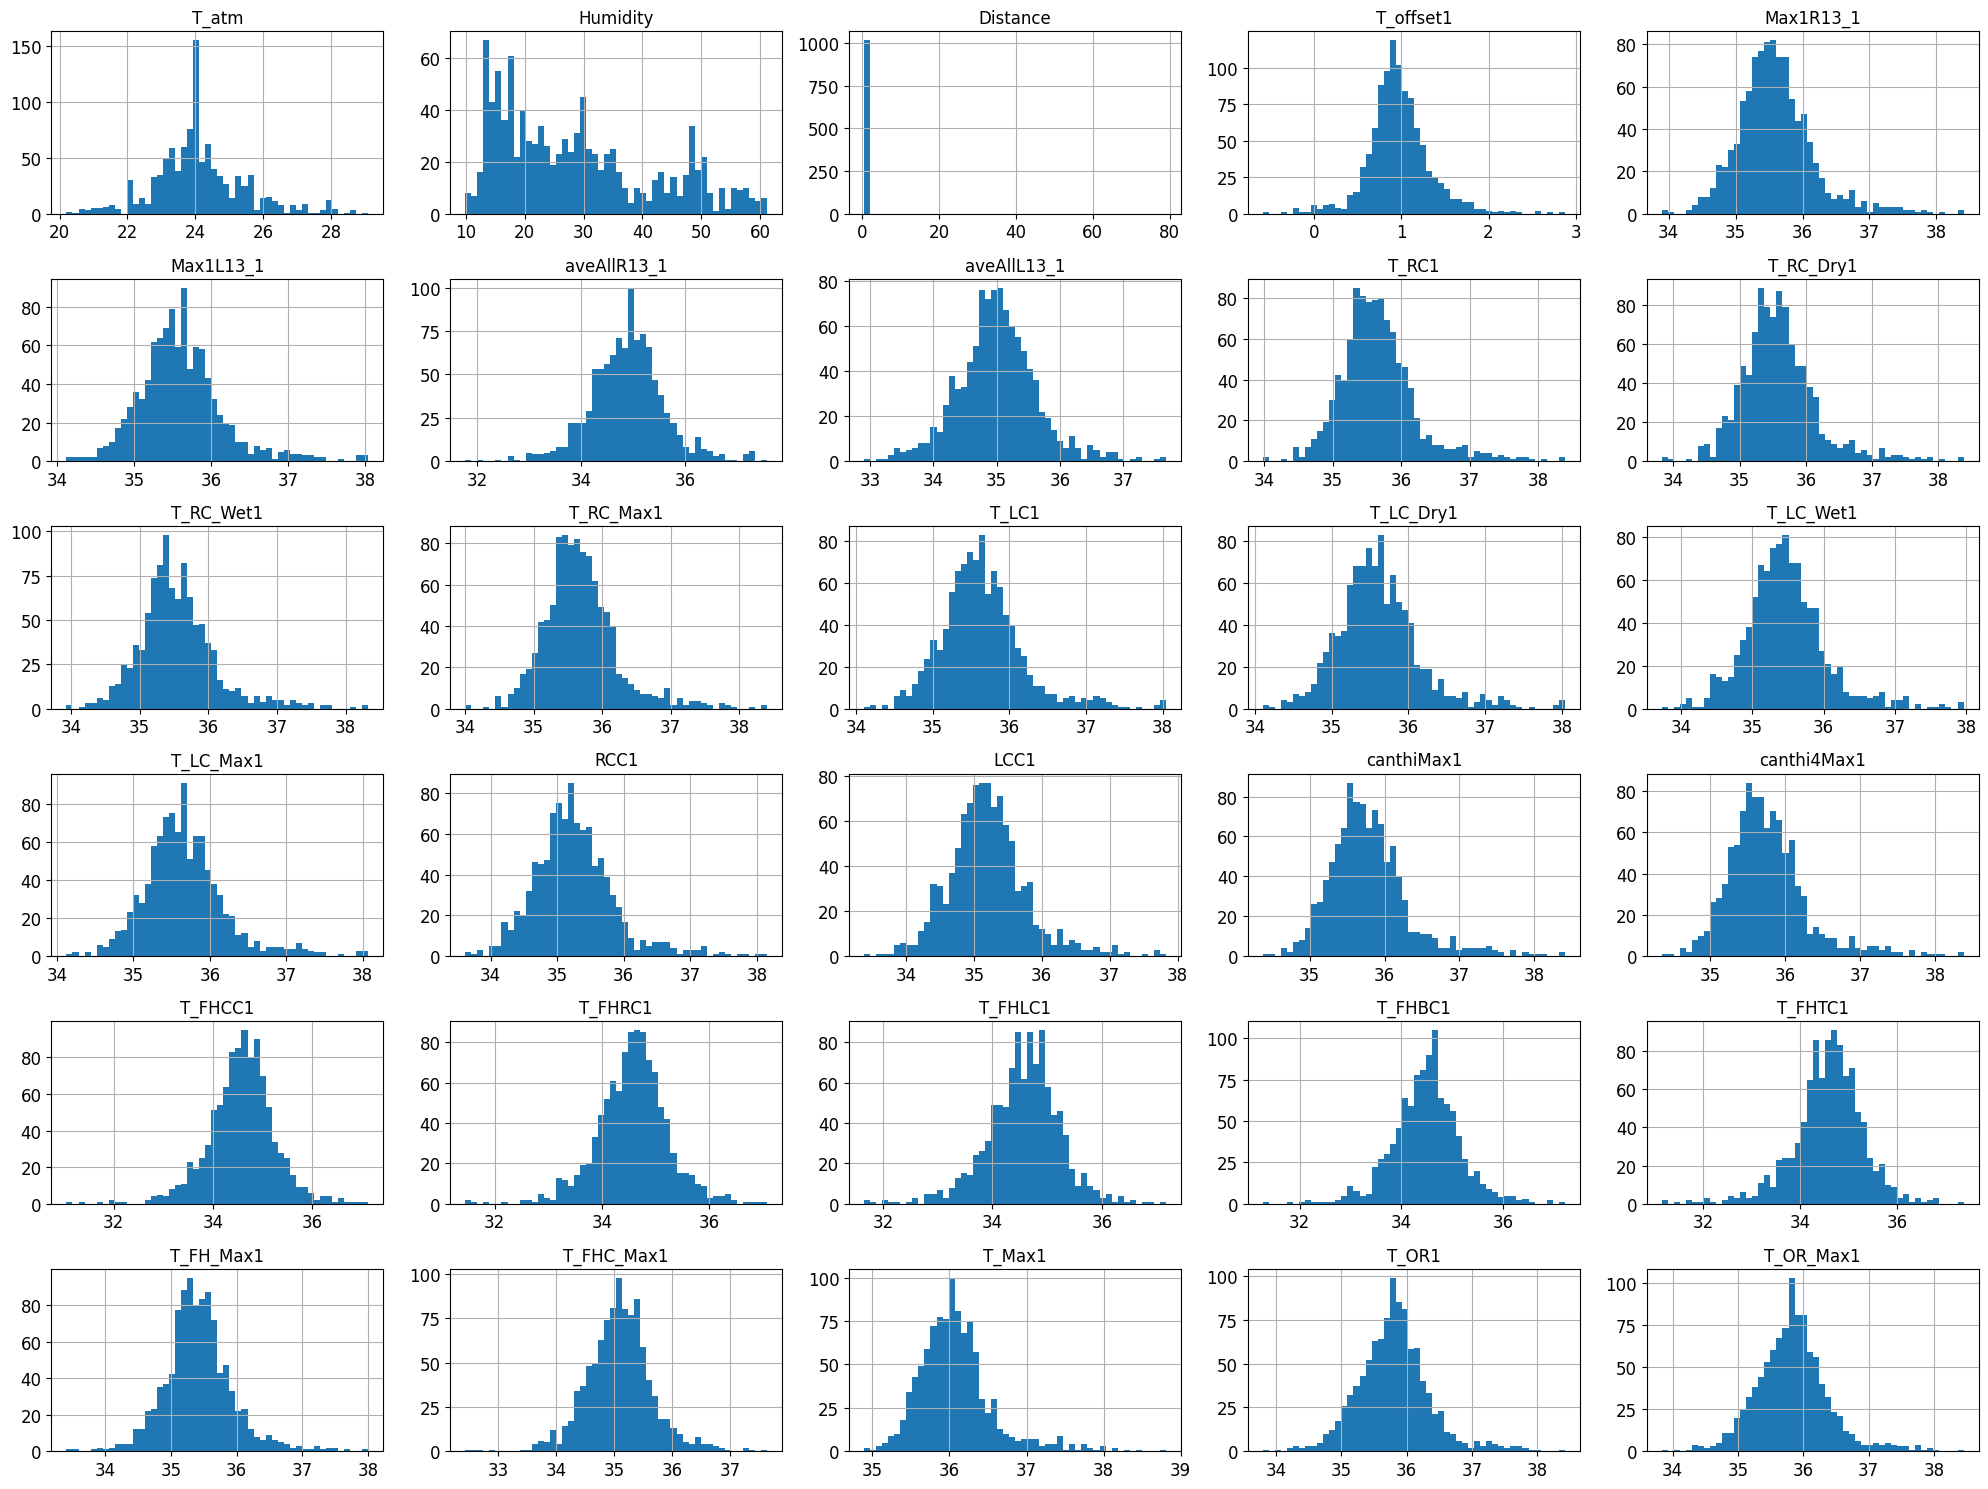

Unique Age Categories and Their Counts:
Age
18-20    534
21-25    355
26-30     67
31-40     31
51-60     11
21-30     10
41-50      9
>60        3
Name: count, dtype: int64


In [4]:
# Visualise the distribution of numerical features
X.hist(bins=50, figsize=(20, 15))
save_fig("features_histogram")
plt.show()

print("Unique Age Categories and Their Counts:")
print(X["Age"].value_counts())

#### **Bar Charts for Categorical Features**

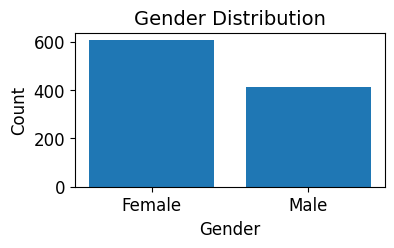

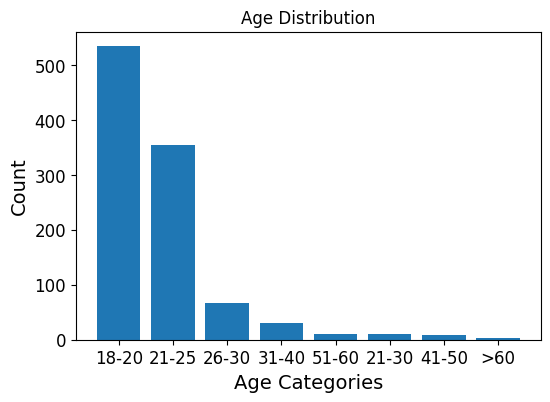

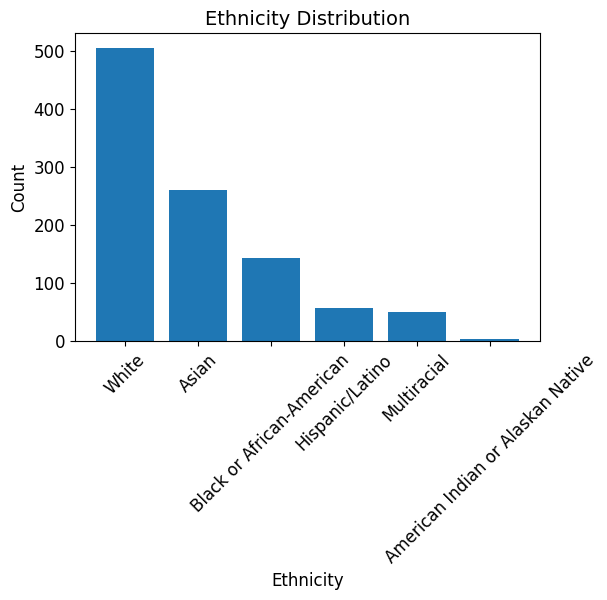

In [5]:
# Bar chart for Gender distribution
gender_counts = X['Gender'].value_counts()
plt.figure(figsize=(4,2))
plt.bar(gender_counts.index, gender_counts.values)
plt.title("Gender Distribution", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

# Bar chart for Age distribution
age_counts = X['Age'].value_counts()
plt.figure(figsize=(6,4))
plt.bar(age_counts.index, age_counts.values)
plt.title("Age Distribution")
plt.xlabel("Age Categories")
plt.ylabel("Count")
plt.show()

# Bar chart for Ethnicity distribution
ethnicity_counts = X['Ethnicity'].value_counts()
plt.figure(figsize=(6,4))
plt.bar(ethnicity_counts.index, ethnicity_counts.values)
plt.title("Ethnicity Distribution", fontsize=14)
plt.xlabel("Ethnicity", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

- Noted an inconsistency on Age feature as besides '21-25' and '26-30' there's also a '21-30' age range.

Saving figure oral_temperature_histogram


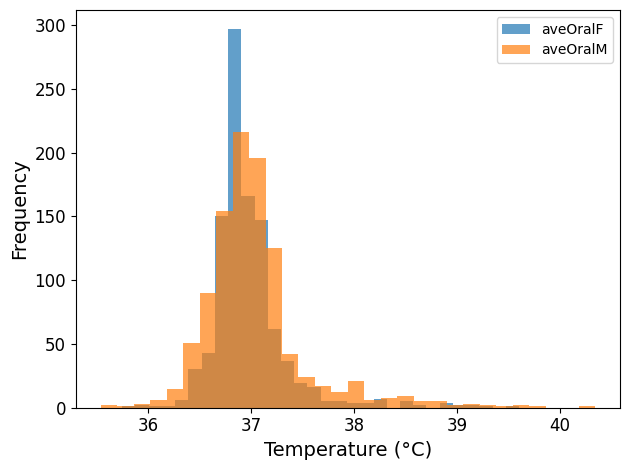

In [6]:
# Checking the distribution of the oral temperature measurements
plt.hist(y['aveOralF'], bins=30, alpha=0.7, label='aveOralF')
plt.hist(y['aveOralM'], bins=30, alpha=0.7, label='aveOralM')
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.legend()
save_fig("oral_temperature_histogram")
plt.show()

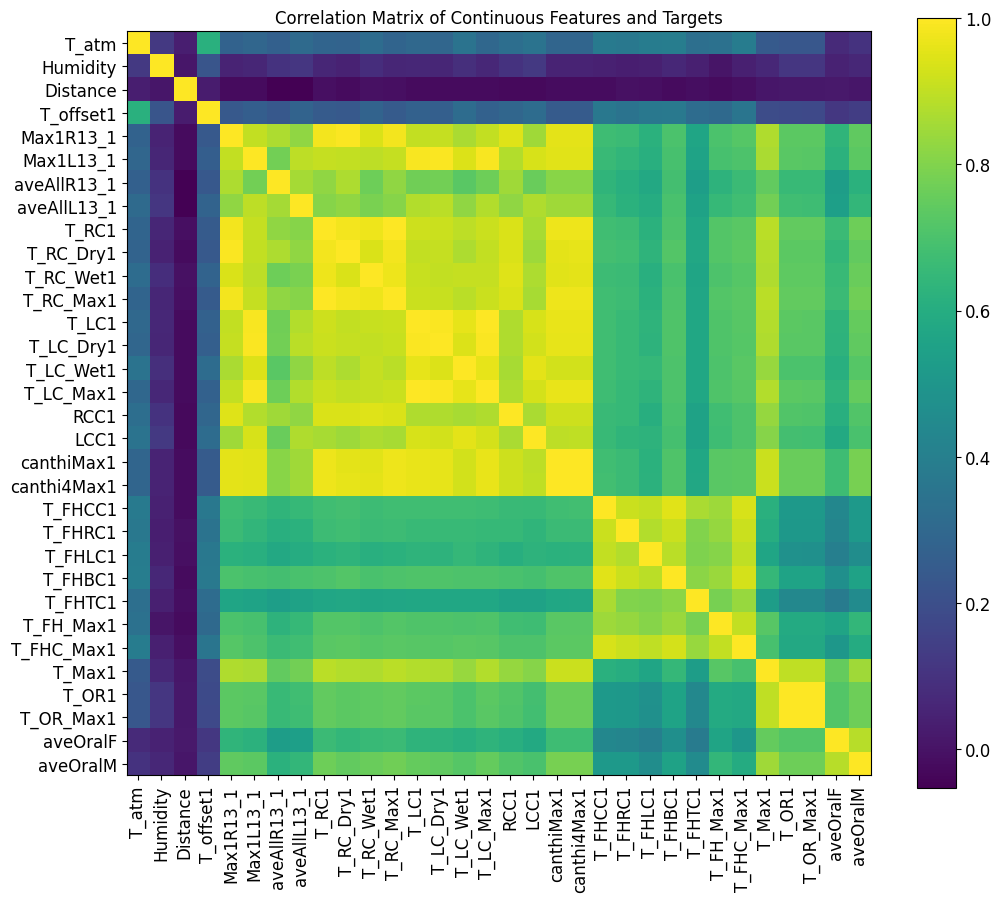

Correlation with aveOralF (Descending):
aveOralF       1.000
aveOralM       0.885
T_Max1         0.753
T_OR1          0.719
T_OR_Max1      0.719
canthiMax1     0.673
canthi4Max1    0.673
T_RC_Max1      0.665
T_RC1          0.664
T_RC_Wet1      0.654
T_RC_Dry1      0.644
Max1R13_1      0.637
T_LC_Max1      0.633
T_LC1          0.633
T_LC_Dry1      0.627
Max1L13_1      0.621
RCC1           0.612
T_LC_Wet1      0.611
LCC1           0.587
T_FH_Max1      0.560
aveAllL13_1    0.541
aveAllR13_1    0.534
T_FHC_Max1     0.502
T_FHBC1        0.472
T_FHCC1        0.433
T_FHRC1        0.426
T_FHLC1        0.400
T_FHTC1        0.383
T_offset1      0.118
T_atm          0.071
Humidity       0.047
Distance       0.016
Name: aveOralF, dtype: float64


Correlation with aveOralM (Descending):
aveOralM       1.000
aveOralF       0.885
T_Max1         0.850
canthiMax1     0.784
canthi4Max1    0.784
T_RC_Max1      0.769
T_RC1          0.769
T_OR1          0.767
T_OR_Max1      0.767
T_RC_Wet1      0.760
T_LC_

In [7]:
# Create a DataFrame with continuous features from X
cont_features = X.select_dtypes(include=[np.number]).copy()

# Merge with the continuous target columns from y.
data_for_corr = pd.concat([cont_features, y[['aveOralF', 'aveOralM']]], axis=1)

# Calculate the correlation matrix
corr_matrix = data_for_corr.corr()

# Plot the correlation matrix using matplotlib
plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, cmap='viridis', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Correlation Matrix of Continuous Features and Targets")
plt.show()


# Get correlation with aveOralF and sort descending
corr_with_aveOralF = corr_matrix['aveOralF'].sort_values(ascending=False)
print("Correlation with aveOralF (Descending):")
print(corr_with_aveOralF.round(3))

print("\n")

# Get correlation with aveOralM and sort descending
corr_with_aveOralM = corr_matrix['aveOralM'].sort_values(ascending=False)
print("Correlation with aveOralM (Descending):")
print(corr_with_aveOralM.round(3))

### **Data Preparation**
#### Creating Fever Classification Targets

We need to create binary classification targets based on the oral temperature measurements:
- **feverF:** 1 if `aveOralF` ≥ 37.5°C, 0 otherwise.
- **feverM:** 1 if `aveOralM` ≥ 37.5°C, 0 otherwise.


In [8]:
# Make an explicit copy
y = y.copy()

# Create new classification target columns in y
y['feverF'] = (y['aveOralF'] >= 37.5).astype(int)
y['feverM'] = (y['aveOralM'] >= 37.5).astype(int)

print("Updated Targets with Fever Classification:")
print(y.head())

# Show distribution of feverF
feverF_counts = y['feverF'].value_counts()
print("\nfeverF Distribution:")
print(feverF_counts)
print(f"Proportion of feverF=1: {feverF_counts[1] / len(y) * 100:.2f}%")

# Show distribution of feverM
feverM_counts = y['feverM'].value_counts()
print("\nfeverM Distribution:")
print(feverM_counts)
print(f"Proportion of feverM=1: {feverM_counts[1] / len(y) * 100:.2f}%")

Updated Targets with Fever Classification:
   aveOralF  aveOralM  feverF  feverM
0     36.85     36.59       0       0
1     37.00     37.19       0       0
2     37.20     37.34       0       0
3     36.85     37.09       0       0
4     36.80     37.04       0       0

feverF Distribution:
feverF
0    955
1     65
Name: count, dtype: int64
Proportion of feverF=1: 6.37%

feverM Distribution:
feverM
0    909
1    111
Name: count, dtype: int64
Proportion of feverM=1: 10.88%


#### **DATA CLEANING**: Fix overlapping Age categories

In [9]:
# Merge '21-25', '26-30', and '21-30' into one category '21-30'
X.loc[X["Age"].isin(["21-25", "26-30", "21-30"]), "Age"] = "21-30"

# Check updated distribution
print("Updated Age Categories and Their Counts:")
print(X["Age"].value_counts())

Updated Age Categories and Their Counts:
Age
18-20    534
21-30    432
31-40     31
51-60     11
41-50      9
>60        3
Name: count, dtype: int64


### **Stratified Train/Test Split**
The binary fever label `feverF` is **highly imbalanced**, with only **6.37%** positive cases. To ensure the rare positive examples are well-represented in both the training and test sets, **stratified sampling** is performed based on `feverF`. Stratification preserves the same fever vs. non-fever ratio across both splits, reducing the risk that the test set ends up with too few positive cases to evaluate the models reliably.

`feverF`, rather than `feverM`, was chosen for stratification because its distribution is more imbalanced (6.37% vs 10.88%). However, since  `aveOralF` and `aveOralM` are strongly correlated (Pearson r ≈ 0.88), stratifying on `feverF` also preserves the distribution of `feverM`, as shown in the proportions below.

In [10]:
from sklearn.model_selection import train_test_split

# Split features and targets for training and testing
# (Using the same split for both regression and classification tasks)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=SEED,
    stratify=y['feverF']
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Check distribution in each set for
def print_fever_distribution(label):
    train_counts = y_train[label].value_counts()
    test_counts = y_test[label].value_counts()

    print(f"\nTraining distribution of {label}:")
    print(train_counts)
    print(f"Proportion of {label}=1: {train_counts[1] / len(y_train) * 100:.2f}%")

    print(f"\nTest distribution of {label}:")
    print(test_counts)
    print(f"Proportion of {label}=1: {test_counts[1] / len(y_test) * 100:.2f}%")
    print("—" * 70)

for fever_label in ["feverF", "feverM"]:
    print_fever_distribution(fever_label)

Training set shape: (816, 33)
Test set shape: (204, 33)

Training distribution of feverF:
feverF
0    764
1     52
Name: count, dtype: int64
Proportion of feverF=1: 6.37%

Test distribution of feverF:
feverF
0    191
1     13
Name: count, dtype: int64
Proportion of feverF=1: 6.37%
——————————————————————————————————————————————————————————————————————

Training distribution of feverM:
feverM
0    728
1     88
Name: count, dtype: int64
Proportion of feverM=1: 10.78%

Test distribution of feverM:
feverM
0    181
1     23
Name: count, dtype: int64
Proportion of feverM=1: 11.27%
——————————————————————————————————————————————————————————————————————


### Train / Validation / Test Strategy

- The dataset is first split into **80% training (816 instances)** and **20% test (204 instances)** using stratified sampling on feverF.  
- For **classification**, an internal validation set is created by taking **20% of the training data** (again stratified on feverF):  
  - Training (classification): 652 rows  
  - Validation (classification): 164 rows  
  - Test (shared for all tasks): 204 rows  

- For **regression**, model selection and tuning rely on **k-fold cross-validation on the full training set (816 rows)**. No separate validation split is used for regression; the test set is only used once at the end for final evaluation.


## Dataset Transformation

In [11]:
# 1. Make Copies of the Split Data (retain unprocessed versions)

X_train_unprocessed = X_train.copy()
X_test_unprocessed = X_test.copy()
y_train_unprocessed = y_train.copy()
y_test_unprocessed = y_test.copy()

In [12]:
# 2. Separate Columns by Type

# Numeric columns: select all numeric columns from the unprocessed training set.
numeric_columns = X_train_unprocessed.select_dtypes(include=[np.number]).columns.tolist()

# Categorical columns: Gender, Ethnicity, and Age, though Age is ordinal
nominal_features = ["Gender", "Ethnicity"]  # No natural ordering
ordinal_feature = ["Age"] # There's a natural ordering (age ranges)


In [13]:
# 3. Define Pipelines for Each Data Type

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# For distance-based models: numeric data is imputed and scaled.
num_pipeline_scaled = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# For tree-based models: numeric data is imputed only (scaling is not needed).
num_pipeline_tree = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

# Categorical pipeline for nominal features: one-hot encoding works well for both cases.
nominal_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

# Categorical pipeline for the ordinal feature 'Age'
# Define the order for age groups.
age_categories = ["18-20", "21-30", "31-40", "41-50", "51-60", ">60"]
ordinal_pipeline = Pipeline([
    ("ordinal", OrdinalEncoder(categories=[age_categories]))
])

In [14]:
# 4. Create Two ColumnTransformers: one for each processing case

from sklearn.compose import ColumnTransformer

# Preprocessor for distance-based models (includes scaling)
preprocessor_scaled = ColumnTransformer([
    ("num", num_pipeline_scaled, numeric_columns),
    ("nominal", nominal_pipeline, nominal_features),
    ("ordinal", ordinal_pipeline, ordinal_feature),
])

# Preprocessor for tree-based models (no scaling for numeric features)
preprocessor_tree = ColumnTransformer([
    ("num", num_pipeline_tree, numeric_columns),
    ("nominal", nominal_pipeline, nominal_features),
    ("ordinal", ordinal_pipeline, ordinal_feature),
])

In [15]:
# 5. Fit and Transform the Training Data, and Transform the Test Data

# For distance-based models:
X_train_scaled = preprocessor_scaled.fit_transform(X_train_unprocessed)
X_test_scaled = preprocessor_scaled.transform(X_test_unprocessed)

# For tree-based models:
X_train_tree = preprocessor_tree.fit_transform(X_train_unprocessed)
X_test_tree = preprocessor_tree.transform(X_test_unprocessed)

print("X_train_scaled shape (for distance-based models):", X_train_scaled.shape)
print("X_test_scaled shape (for distance-based models):", X_test_scaled.shape)

print("X_train_tree shape (for tree-based models):", X_train_tree.shape)
print("X_test_tree shape (for tree-based models):", X_test_tree.shape)

print("\n-----\n")


# Confirm the imputation by checking for missing values after transformation
print("\nAny missing values after preprocessing (tree-based)?", np.isnan(X_train_tree).sum())
print("\nAny missing values after preprocessing (scaled)?", np.isnan(X_train_scaled).sum())

print("\n-----\n")


# Show a few rows of the scaled data
print("\nFirst 5 rows of X_train_scaled (Distance-Based Models):")
print(pd.DataFrame(X_train_scaled).head())

print("\n-----\n")


# Check mean ≈ 0 and std ≈ 1 for numeric features
scaled_df = pd.DataFrame(X_train_scaled)
print("\nMeans of scaled features (should be ~0):")
print(scaled_df.mean().round(2))

print("\nStandard deviations of scaled features (should be ~1):")
print(scaled_df.std().round(2))


X_train_scaled shape (for distance-based models): (816, 39)
X_test_scaled shape (for distance-based models): (204, 39)
X_train_tree shape (for tree-based models): (816, 39)
X_test_tree shape (for tree-based models): (204, 39)

-----


Any missing values after preprocessing (tree-based)? 0

Any missing values after preprocessing (scaled)? 0

-----


First 5 rows of X_train_scaled (Distance-Based Models):
         0         1         2         3         4         5         6   \
0 -0.367547 -0.931358 -0.054216 -0.758881  3.073577  2.704822  2.692888   
1 -0.586945 -1.144106 -0.017744 -0.911655 -0.363476 -0.990509 -1.172087   
2  1.533908  1.492447 -0.054216  2.428858 -0.483510 -0.370025  0.057678   
3  0.436915  2.297849 -0.054216  0.527160  0.579225  0.705482  0.902341   
4 -1.025742  1.583624 -0.054216 -2.694783 -1.919519 -2.318806 -1.492035   

         7         8         9   ...        29   30   31   32   33   34   35  \
0  2.297473  3.115005  3.150568  ...  2.594967  0.0  1.0  0.0 

The increase from 33 raw features to 39 preprocessed features comes from the encoding of the categorical variables:
- numeric features remain as 30 continuous columns  
- Gender is one-hot encoded into two binary columns  
- Ethnicity is one-hot encoded into six columns present in the training split  
- Age becomes one ordinal-coded numeric (float) column  

Taken together this yields 30 + 2 + 6 + 1 = 39 input columns used by all models.


**Distance-Based Models**:
Use `num_pipeline_scaled` that imputes missing values and scales (`StandardScaler`) numeric features. This version (saved as `X_train_scaled` and `X_test_scaled`) is ideal for models like Linear Regression, k-NN, and Neural Networks which are sensitive to feature scaling.

**Tree-Based Models**:
Use `num_pipeline_tree` that only imputes missing values (without scaling) because tree-based models (like Decision Trees and Random Forests) are invariant to monotonic transformations of numeric features. This version (saved as `X_train_tree` and `X_test_tree`) is ready for these models.

<br>

***Note on validation and scaling***:

*In this project, the feature scaler was fitted on the full training set before running cross-validation. This makes the **validation** scores **slightly optimistic**, because each fold benefited from scaling information from all training samples. The **test set was never touched** during training or model selection, so the final test results remain **unbiased**. In a production setting, this would be handled with a scikit-learn Pipeline to refit scaling inside each fold.*

***Note on encodings***:

*Only the numeric columns are standardised. The one-hot and ordinal encodings for categorical variables keep their original scale, so their means and standard deviations are not expected to be ~0 and ~1.*

<br>

---
<br>

# **Model Training, Evaluation, and Tuning**
# Regression Task

#### **Setup & Utility Functions (Regression)**

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures

import tensorflow as tf
from tensorflow import keras

import pkgutil
if not pkgutil.find_loader("keras_tuner"):
    !pip install keras-tuner > /dev/null 2>&1


# Make TensorFlow / Keras deterministic
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()


# Helper function to evaluate any regression model on a test set using RMSE, MAE, and R²
def evaluate_regression_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name} Evaluation:")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R²: {r2:.3f}")

    return y_pred


# Helper function to plot predicted values against actual values for any regression model
def plot_actual_vs_predicted(y_true, y_pred, model_name):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, y_pred, alpha=0.6, color='teal', label='Predicted vs Actual')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect Prediction')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted: {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()


# Helper function to compute cross-validated RMSE for any regression model
def cross_val_rmse(model, X_train, y_train, cv=10):
    neg_mse_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)
    rmse_scores = np.sqrt(-neg_mse_scores)
    print(f"CV RMSE: {rmse_scores.mean()}")
    print(f"CV RMSE (std): {rmse_scores.std()}")
    return rmse_scores


# Helper function to visualise top positive and negative feature importances based on model coefficients
def plot_feature_coefficients(model, preprocessor, model_name, top_n=10):
    # Extract coefficients and feature names from preprocessor
    coefs = model.coef_
    feature_names = preprocessor.get_feature_names_out()

    # Create DataFrame
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefs
    })

    # Sort by coefficient values
    coef_df_sorted = coef_df.sort_values(by='Coefficient', ascending=False)

    # Select top positive and negative
    top_positive = coef_df_sorted.head(top_n)
    top_negative = coef_df_sorted.tail(top_n)
    combined = pd.concat([top_positive, top_negative])
    combined = combined.sort_values(by='Coefficient')

    # Plot
    plt.figure(figsize=(10, 6))
    colors = ['green' if c > 0 else 'red' for c in combined['Coefficient']]
    plt.barh(combined['Feature'], combined['Coefficient'], color=colors)
    plt.axvline(0, color='black', linestyle='--')
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.title(f"Top ±{top_n} Feature Coefficients: {model_name}")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

<br>

---

## **A. Linear Regression (Baseline)**

Cross-Validation Results:

aveOralF:
CV RMSE: 0.4380190335581161
CV RMSE (std): 0.5766226432243827

aveOralM:
CV RMSE: 0.42999014463502183
CV RMSE (std): 0.5091953738410786
------------------------------

Test Set Evaluation:

Linear Regression (aveOralF) Evaluation:
RMSE: 0.239
MAE: 0.182
R²: 0.645

Linear Regression (aveOralM) Evaluation:
RMSE: 0.267
MAE: 0.204
R²: 0.759
------------------------------


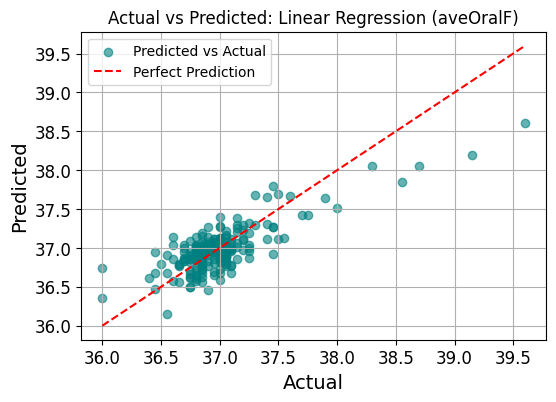

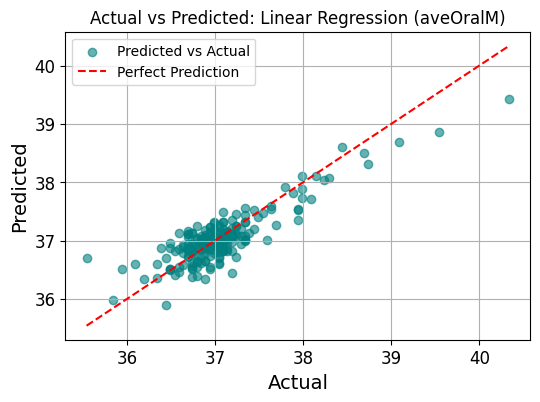

In [17]:
# Initialize the Linear Regression model
lin_reg = LinearRegression()

# Fit the model for both targets
lin_reg.fit(X_train_scaled, y_train['aveOralF'])
lin_reg_m = LinearRegression()
lin_reg_m.fit(X_train_scaled, y_train['aveOralM'])

# Cross-validation RMSE for both targets
print("Cross-Validation Results:")
print("\naveOralF:")
cross_val_rmse(lin_reg, X_train_scaled, y_train['aveOralF'])
print("\naveOralM:")
cross_val_rmse(lin_reg_m, X_train_scaled, y_train['aveOralM'])
print("-" * 30)

# Evaluation on test set
print("\nTest Set Evaluation:")
y_pred_f = evaluate_regression_model(lin_reg, X_test_scaled, y_test['aveOralF'], model_name="Linear Regression (aveOralF)")
y_pred_m = evaluate_regression_model(lin_reg_m, X_test_scaled, y_test['aveOralM'], model_name="Linear Regression (aveOralM)")
print("-" * 30)

# Plot actual vs predicted for both
plot_actual_vs_predicted(y_test['aveOralF'], y_pred_f, model_name="Linear Regression (aveOralF)")
plot_actual_vs_predicted(y_test['aveOralM'], y_pred_m, model_name="Linear Regression (aveOralM)")

# Helper function to RETURN metrics
def get_regression_metrics(model, X_test, y_test):
    # Silence Keras progress bars if 'verbose' exists
    try:
        y_pred = model.predict(X_test, verbose=0)
    except TypeError:
        y_pred = model.predict(X_test)

    y_pred = np.asarray(y_pred).flatten()

    return {
        "R2": r2_score(y_test, y_pred),
        "RMSE": round(np.sqrt(mean_squared_error(y_test, y_pred)), 3),
        "MAE": round(mean_absolute_error(y_test, y_pred), 3)
    }

### **Feature Importance: Linear Regression Coefficients**

Feature Importance:


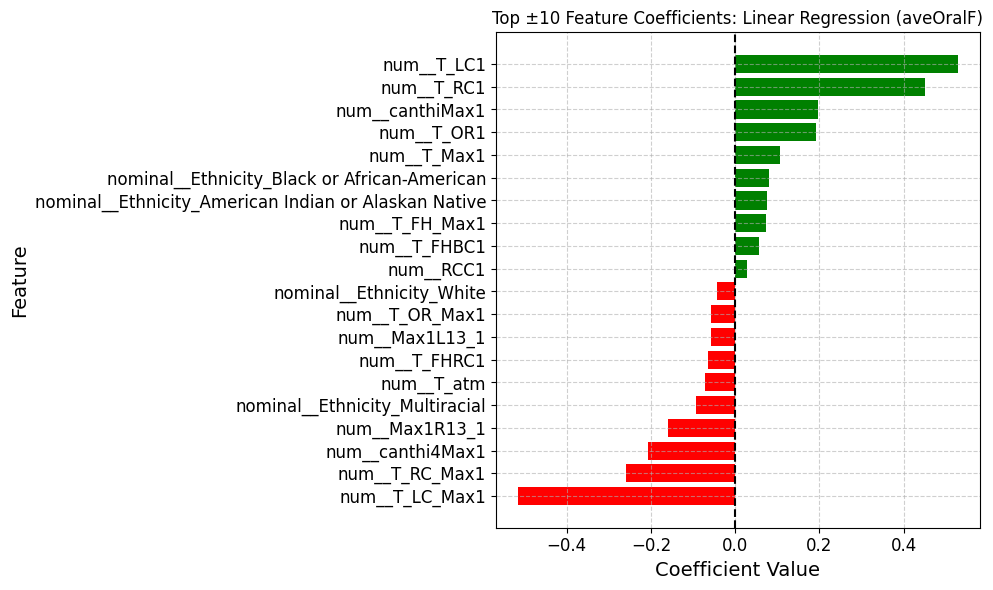

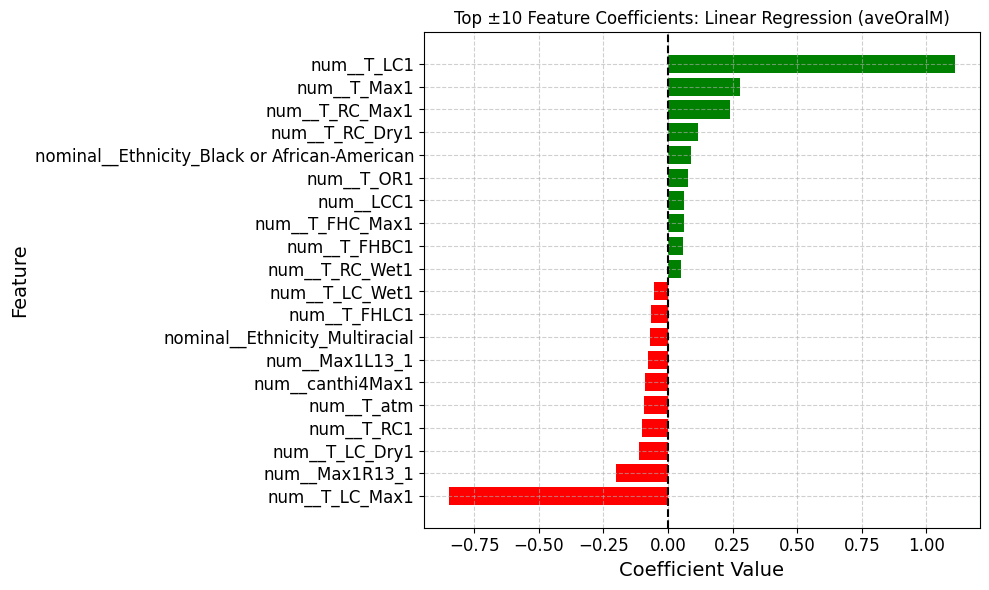

In [18]:
# Feature Importance Plots
print("Feature Importance:")
plot_feature_coefficients(lin_reg, preprocessor_scaled, model_name="Linear Regression (aveOralF)", top_n=10)
print()
plot_feature_coefficients(lin_reg_m, preprocessor_scaled, model_name="Linear Regression (aveOralM)", top_n=10)

As a baseline model, Linear Regression provided a good performance, especially for `aveOralM` (R² ≈ 0.759), indicating a strong linear relationship between the input features and the target. For `aveOralF`, the performance was slightly lower (R² ≈ 0.645), suggesting that while key predictors contribute linearly, some nonlinear patterns may limit model accuracy.

The top positive predictors for aveOralF included `T_LC1`, `T_RC1`, `canthiMax1`, and `T_OR1`. Interestingly, ethnicity variables such as `Ethnicity_Black or African-American` and `Ethnicity_American Indian or Alaskan Native` also showed moderate positive coefficients, suggesting possible demographic variation in temperature patterns.

On the negative side, `T_LC_Max1`, `T_RC_Max1`, and `canthi4Max1` were most influential. These features may reflect less stable temperature zones,  weakening oral temperature predictions.

Despite its simplicity, the model achieved low RMSE and MAE, which could make it a reliable benchmark.

<br>

---
<br>
    
## **B. Ridge Regression**

Ridge Regression Best Alphas:

aveOralF alpha = 100
aveOralM alpha = 10
------------------------------

Cross-Validation RMSE:

aveOralF:
CV RMSE: 0.24453862396178558
CV RMSE (std): 0.038236592535504606

aveOralM:
CV RMSE: 0.25634149440686177
CV RMSE (std): 0.023749609665449412
------------------------------

Test Set Evaluation:

Ridge Regression (aveOralF) Evaluation:
RMSE: 0.236
MAE: 0.175
R²: 0.656

Ridge Regression (aveOralM) Evaluation:
RMSE: 0.266
MAE: 0.201
R²: 0.762
------------------------------


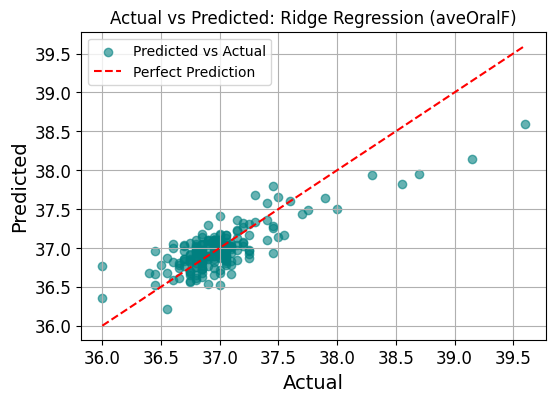

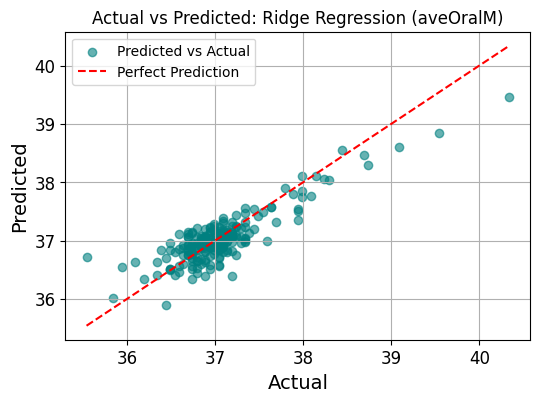

In [19]:
# Hyperparameter tuning
ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Helper function to perform GridSearchCV for Ridge regression
def tune_ridge(X_train, y_train, param_grid, cv=10):
    ridge = Ridge(random_state=SEED)
    grid_search = GridSearchCV(
        ridge,
        param_grid,
        scoring='neg_mean_squared_error',
        cv=cv,
        return_train_score=True
    )
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_['alpha']


# Perform tuning
best_ridge_f, best_alpha_f = tune_ridge(X_train_scaled, y_train['aveOralF'], ridge_params)
best_ridge_m, best_alpha_m = tune_ridge(X_train_scaled, y_train['aveOralM'], ridge_params)

# Show best alpha values
print("Ridge Regression Best Alphas:\n")
print(f"aveOralF alpha = {best_alpha_f}")
print(f"aveOralM alpha = {best_alpha_m}")
print("-" * 30)

# Cross-validation RMSE for both targets
print("\nCross-Validation RMSE:")
print("\naveOralF:")
cross_val_rmse(best_ridge_f, X_train_scaled, y_train['aveOralF'])
print("\naveOralM:")
cross_val_rmse(best_ridge_m, X_train_scaled, y_train['aveOralM'])
print("-" * 30)

# Test Set Evaluation
print("\nTest Set Evaluation:")
y_pred_ridge_f = evaluate_regression_model(
    best_ridge_f, X_test_scaled, y_test['aveOralF'], model_name="Ridge Regression (aveOralF)"
)
y_pred_ridge_m = evaluate_regression_model(
    best_ridge_m, X_test_scaled, y_test['aveOralM'], model_name="Ridge Regression (aveOralM)"
)
print("-" * 30)

# Plot actual vs predicted values
plot_actual_vs_predicted(y_test['aveOralF'], y_pred_ridge_f, model_name="Ridge Regression (aveOralF)")
plot_actual_vs_predicted(y_test['aveOralM'], y_pred_ridge_m, model_name="Ridge Regression (aveOralM)")

### **Feature Importance: Ridge Regression Coefficients**

Feature Importance:


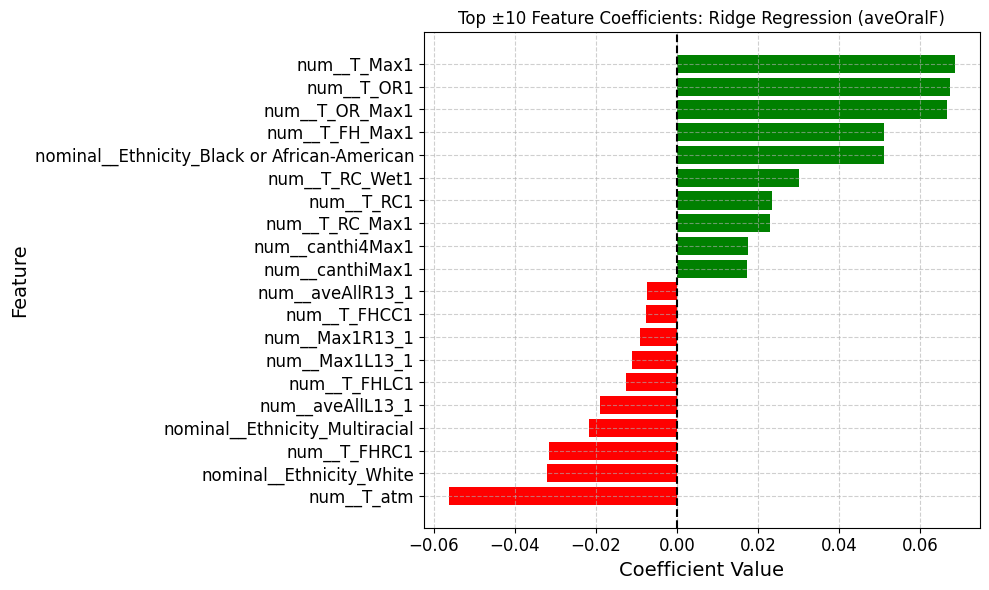

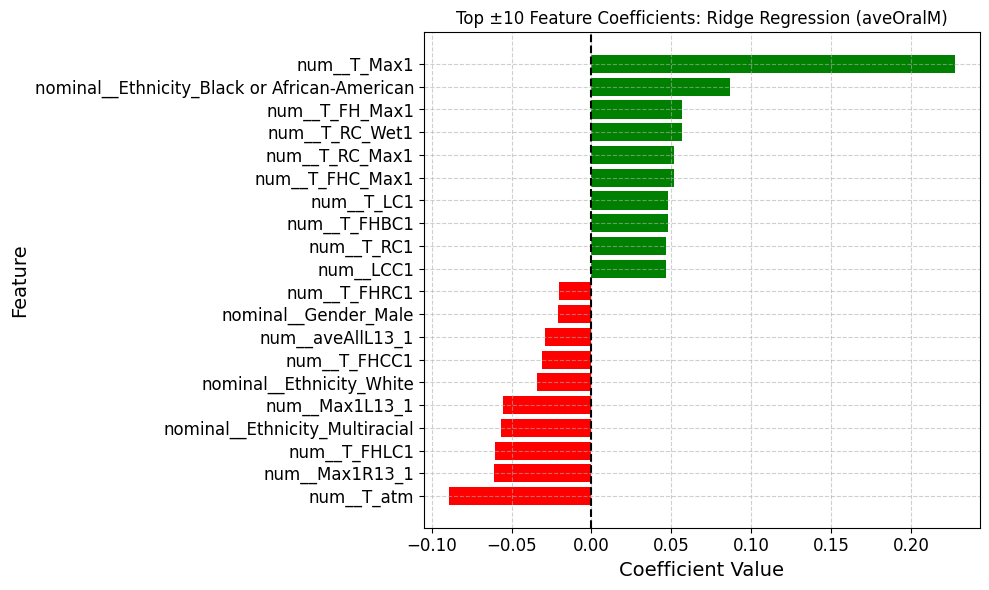

In [20]:
# Feature Importance Plots
print("Feature Importance:")
plot_feature_coefficients(best_ridge_f, preprocessor_scaled, model_name="Ridge Regression (aveOralF)", top_n=10)
print()
plot_feature_coefficients(best_ridge_m, preprocessor_scaled, model_name="Ridge Regression (aveOralM)", top_n=10)

For `aveOralM`, Ridge achieved an R² of ≈ 0.762, maintaining strong predictive power similar to the baseline linear model, with slightly improved stability shown by its lower CV standard deviation.

For `aveOralF`, Ridge slightly outperformed Linear Regression (R² ≈ 0.656 vs. 0.645), indicating that regularisation helped counter mild multicollinearity or noise in the features.

<br>

---
<br>

## **C. Lasso Regression**

Lasso Regression Best Alphas:

aveOralF alpha = 0.001
aveOralM alpha = 0.001
------------------------------

Cross-Validation RMSE:

aveOralF:
CV RMSE: 0.24440319952701878
CV RMSE (std): 0.03547206651134518

aveOralM:
CV RMSE: 0.25532003619697635
CV RMSE (std): 0.02465819215810818
------------------------------

Test Set Evaluation:

Lasso Regression (aveOralF) Evaluation:
RMSE: 0.236
MAE: 0.178
R²: 0.655

Lasso Regression (aveOralM) Evaluation:
RMSE: 0.265
MAE: 0.200
R²: 0.763
------------------------------


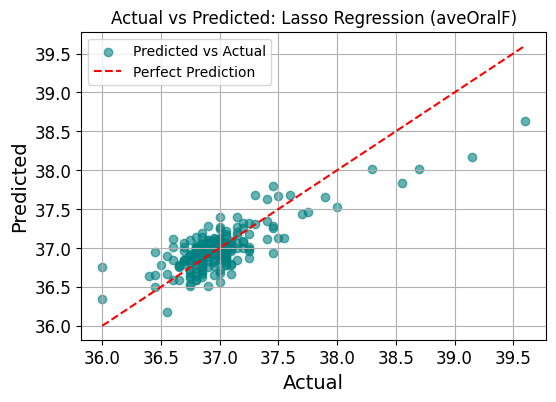

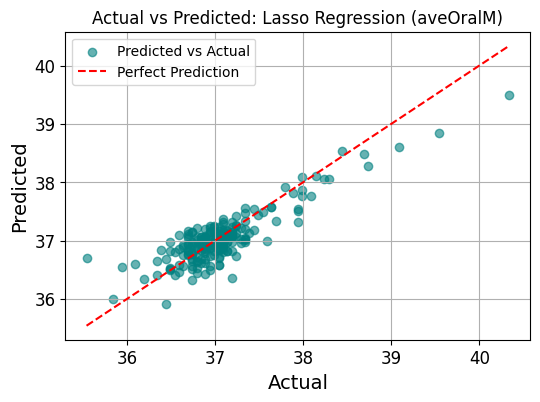

In [21]:
# Hyperparameter tuning
lasso_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

# Helper function to perform GridSearchCV for Lasso regression
def tune_lasso(X_train, y_train, param_grid, cv=10):
    lasso = Lasso(random_state=SEED, max_iter=10000)
    grid_search = GridSearchCV(
        lasso,
        param_grid,
        scoring='neg_mean_squared_error',
        cv=cv,
        return_train_score=True
    )
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_['alpha']


# Perform tuning
best_lasso_f, best_alpha_lasso_f = tune_lasso(X_train_scaled, y_train['aveOralF'], lasso_params)
best_lasso_m, best_alpha_lasso_m = tune_lasso(X_train_scaled, y_train['aveOralM'], lasso_params)

# Show best alpha values
print("Lasso Regression Best Alphas:\n")
print(f"aveOralF alpha = {best_alpha_lasso_f}")
print(f"aveOralM alpha = {best_alpha_lasso_m}")
print("-" * 30)

# Cross-validation RMSE for both targets
print("\nCross-Validation RMSE:")
print("\naveOralF:")
cross_val_rmse(best_lasso_f, X_train_scaled, y_train['aveOralF'])
print("\naveOralM:")
cross_val_rmse(best_lasso_m, X_train_scaled, y_train['aveOralM'])
print("-" * 30)

# Test Set Evaluation
print("\nTest Set Evaluation:")
y_pred_lasso_f = evaluate_regression_model(
    best_lasso_f, X_test_scaled, y_test['aveOralF'], model_name="Lasso Regression (aveOralF)"
)
y_pred_lasso_m = evaluate_regression_model(
    best_lasso_m, X_test_scaled, y_test['aveOralM'], model_name="Lasso Regression (aveOralM)"
)
print("-" * 30)

# Plot actual vs predicted values
plot_actual_vs_predicted(y_test['aveOralF'], y_pred_lasso_f, model_name="Lasso Regression (aveOralF)")
plot_actual_vs_predicted(y_test['aveOralM'], y_pred_lasso_m, model_name="Lasso Regression (aveOralM)")


### **Feature Importance: Lasso Regression Coefficients**

Feature Importance:


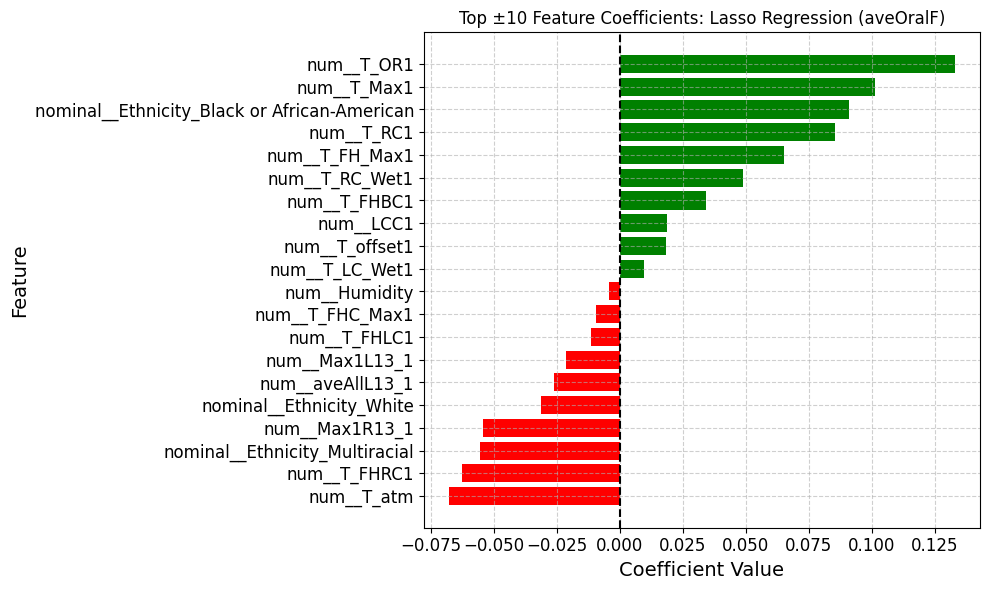

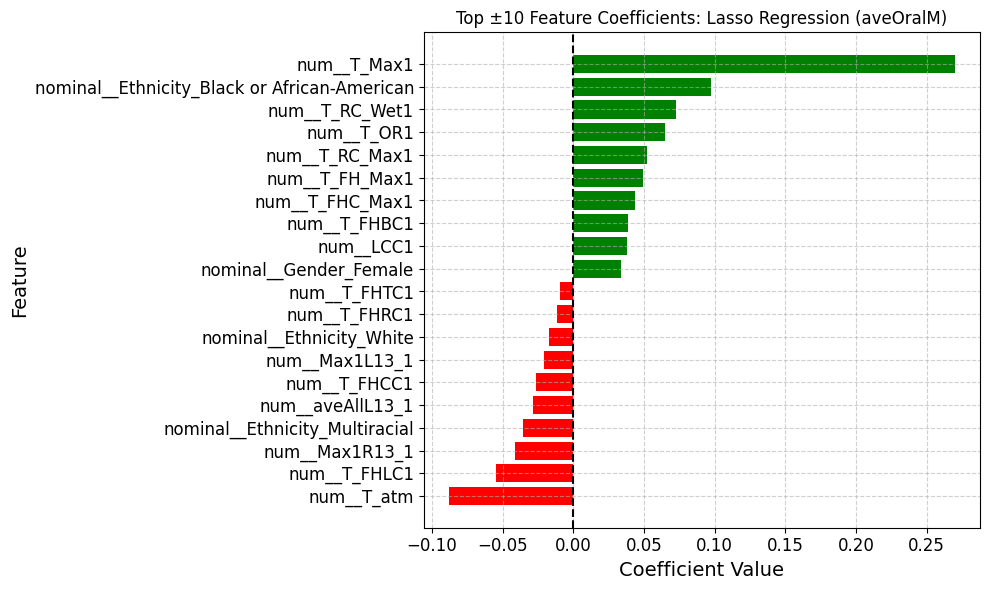

In [22]:
# Feature Importance Plots
print("Feature Importance:")
plot_feature_coefficients(best_lasso_f, preprocessor_scaled, model_name="Lasso Regression (aveOralF)", top_n=10)
print()
plot_feature_coefficients(best_lasso_m, preprocessor_scaled, model_name="Lasso Regression (aveOralM)", top_n=10)

For both `aveOralF` and `aveOralM`, the best-performing alpha was very small (alpha=0.001), indicating that only minimal regularisation was needed to improve generalisation. The R² scores (≈ 0.655 for aveOralF, ≈ 0.763 for aveOralM) were almost identical to Ridge and Linear Regression, showing that Lasso maintained comparable accuracy while simplifying the model.

<br>

---
<br>

## **D. Elastic Net Regression**

Elastic Net Regression Best Hyperparameters:

aveOralF -> alpha: 0.01, l1_ratio: 0.1
aveOralM -> alpha: 0.01, l1_ratio: 0.1
------------------------------

Cross-Validation RMSE:

aveOralF:
CV RMSE: 0.24389637136324183
CV RMSE (std): 0.036045721614915094

aveOralM:
CV RMSE: 0.2548857115612536
CV RMSE (std): 0.024551236805383368
------------------------------

Test Set Evaluation:

Elastic Net Regression (aveOralF) Evaluation:
RMSE: 0.236
MAE: 0.177
R²: 0.656

Elastic Net Regression (aveOralM) Evaluation:
RMSE: 0.265
MAE: 0.200
R²: 0.762
------------------------------


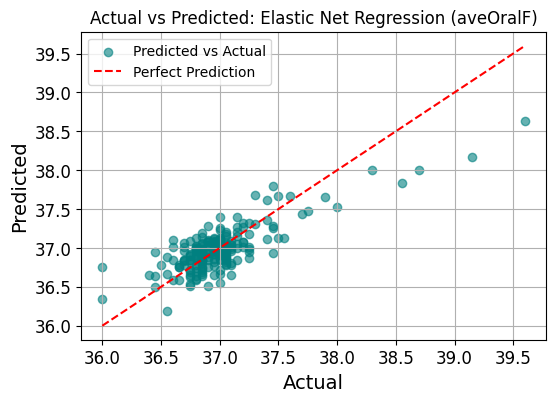

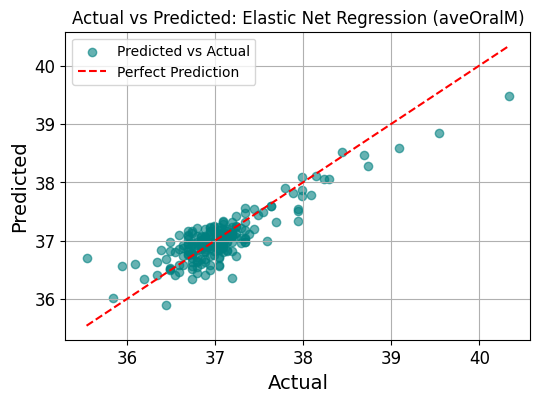

In [23]:
# Hyperparameter tuning
elastic_params = {
    'alpha': [0.001, 0.01, 0.1, 1],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Helper function to perform GridSearchCV for ElasticNet regression
def tune_elasticnet(X_train, y_train, param_grid, cv=10):
    elastic = ElasticNet(random_state=SEED, max_iter=10000)
    grid_search = GridSearchCV(
        elastic,
        param_grid,
        scoring='neg_mean_squared_error',
        cv=cv,
        return_train_score=True
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_alpha = grid_search.best_params_['alpha']
    best_l1_ratio = grid_search.best_params_['l1_ratio']
    return best_model, best_alpha, best_l1_ratio


# Perform tuning
best_elastic_f, alpha_f, l1_ratio_f = tune_elasticnet(X_train_scaled, y_train['aveOralF'], elastic_params)
best_elastic_m, alpha_m, l1_ratio_m = tune_elasticnet(X_train_scaled, y_train['aveOralM'], elastic_params)

# Show best parameters
print("Elastic Net Regression Best Hyperparameters:\n")
print(f"aveOralF -> alpha: {alpha_f}, l1_ratio: {l1_ratio_f}")
print(f"aveOralM -> alpha: {alpha_m}, l1_ratio: {l1_ratio_m}")
print("-" * 30)

# Cross-validation RMSE for both targets
print("\nCross-Validation RMSE:")
print("\naveOralF:")
cross_val_rmse(best_elastic_f, X_train_scaled, y_train['aveOralF'])
print("\naveOralM:")
cross_val_rmse(best_elastic_m, X_train_scaled, y_train['aveOralM'])
print("-" * 30)

# Test Set Evaluation
print("\nTest Set Evaluation:")
y_pred_elastic_f = evaluate_regression_model(
    best_elastic_f, X_test_scaled, y_test['aveOralF'], model_name="Elastic Net Regression (aveOralF)"
)
y_pred_elastic_m = evaluate_regression_model(
    best_elastic_m, X_test_scaled, y_test['aveOralM'], model_name="Elastic Net Regression (aveOralM)"
)
print("-" * 30)

# Plot actual vs predicted values
plot_actual_vs_predicted(y_test['aveOralF'], y_pred_elastic_f, model_name="Elastic Net Regression (aveOralF)")
plot_actual_vs_predicted(y_test['aveOralM'], y_pred_elastic_m, model_name="Elastic Net Regression (aveOralM)")

### **Feature Importance: Elastic Net Coefficients**

Feature Importance:


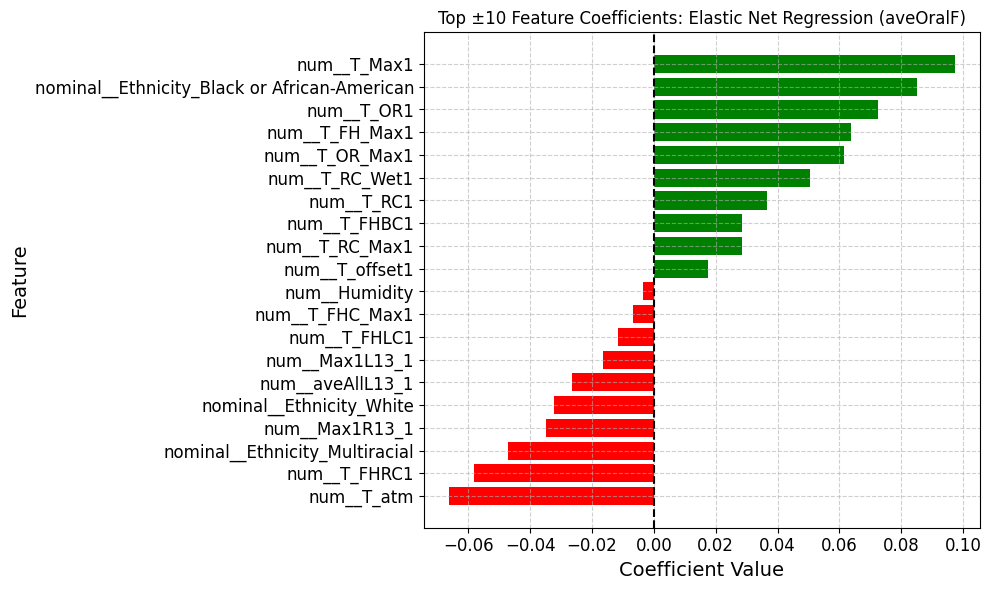

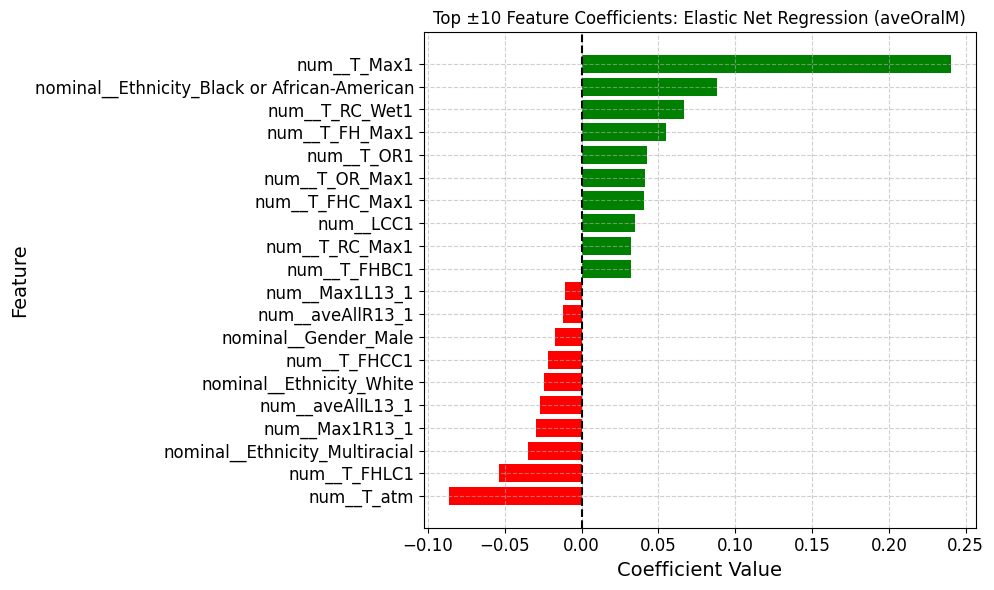

In [24]:
# Feature Importance Plots
print("Feature Importance:")
plot_feature_coefficients(best_elastic_f, preprocessor_scaled, model_name="Elastic Net Regression (aveOralF)", top_n=10)
plot_feature_coefficients(best_elastic_m, preprocessor_scaled, model_name="Elastic Net Regression (aveOralM)", top_n=10)

For both `aveOralF` and `aveOralM`, the best hyperparameters were alpha = 0.01 and l1_ratio = 0.1, leaning more toward Ridge-like behavior.

Performance was nearly identical to Ridge and Lasso, with R² scores around 0.656 for aveOralF and 0.762 for aveOralM, along with low RMSE and MAE values. This suggests that the additional flexibility of Elastic Net didn’t significantly outperform the simpler models but provided a good regularised model.

<br>

---
<br>

## **E. Polynomial Regression**

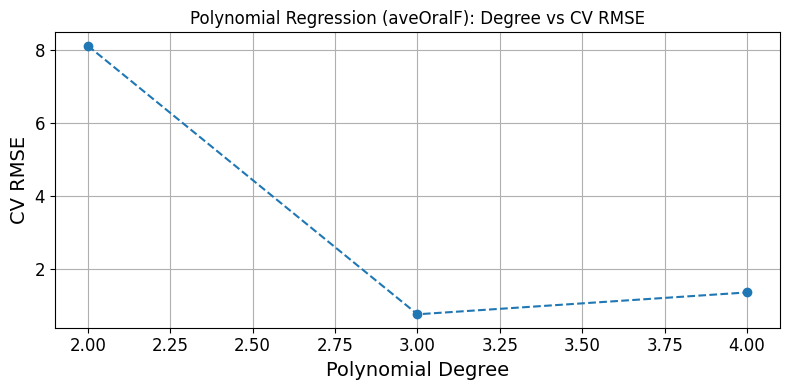

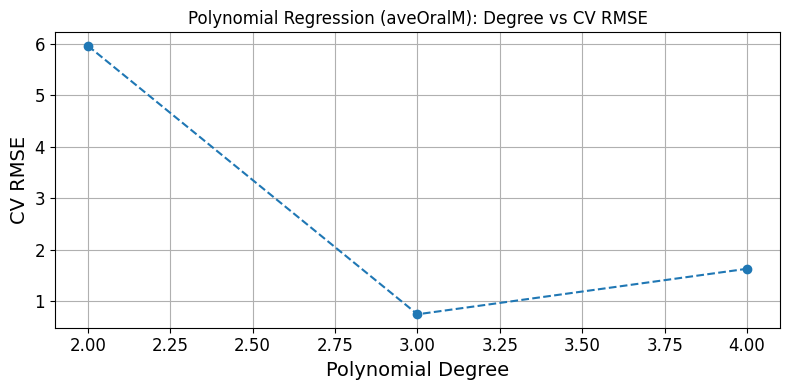

Polynomial Regression Best Hyperparameters:

aveOralF -> degree: 2, alpha: 10
aveOralM -> degree: 2, alpha: 10
------------------------------

Test Set Evaluation:

Polynomial Regression (aveOralF) Evaluation:
RMSE: 0.260
MAE: 0.197
R²: 0.581

Polynomial Regression (aveOralM) Evaluation:
RMSE: 0.293
MAE: 0.229
R²: 0.711
------------------------------


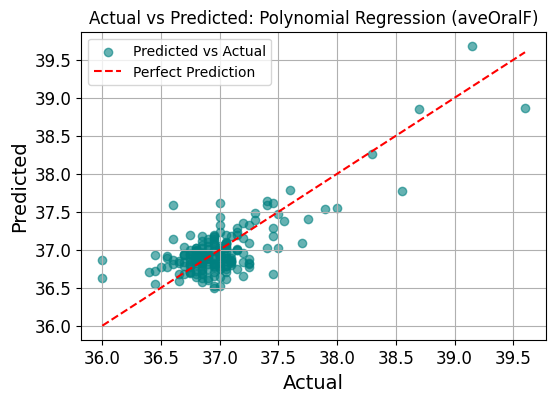

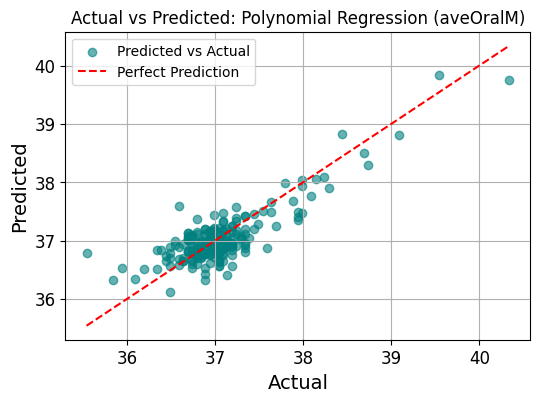

In [25]:
# Hyperparameter tuning
poly_params = {
    "poly__degree": [2, 3, 4],
    "ridge__alpha": [0.001, 0.01, 0.1, 1, 10]
}

# Helper function to tune polynomial ridge and return model, best params, and cv results
def tune_poly_ridge_and_plot(X_train, y_train, target_name, param_grid):
    pipeline = Pipeline([
        ("poly", PolynomialFeatures(include_bias=False)),
        ("ridge", Ridge())
    ])
    grid_search = GridSearchCV(
        pipeline, param_grid,
        scoring="neg_mean_squared_error",
        cv=10, return_train_score=True
    )
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    results_df = pd.DataFrame(grid_search.cv_results_)
    grouped = results_df.groupby("param_poly__degree")["mean_test_score"].min()
    rmse_by_degree = np.sqrt(-grouped)

    plt.figure(figsize=(8, 4))
    plt.plot(rmse_by_degree.index, rmse_by_degree.values, marker='o', linestyle='--')
    plt.xlabel("Polynomial Degree")
    plt.ylabel("CV RMSE")
    plt.title(f"Polynomial Regression ({target_name}): Degree vs CV RMSE")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return grid_search.best_estimator_, best_params

# Fit for both targets
best_poly_f, params_f = tune_poly_ridge_and_plot(X_train_scaled, y_train['aveOralF'], "aveOralF", poly_params)
best_poly_m, params_m = tune_poly_ridge_and_plot(X_train_scaled, y_train['aveOralM'], "aveOralM", poly_params)

# Show best hyperparameters
print("Polynomial Regression Best Hyperparameters:\n")
print(f"aveOralF -> degree: {params_f['poly__degree']}, alpha: {params_f['ridge__alpha']}")
print(f"aveOralM -> degree: {params_m['poly__degree']}, alpha: {params_m['ridge__alpha']}")
print("-" * 30)

# Test Set Evaluation
print("\nTest Set Evaluation:")
y_pred_poly_f = evaluate_regression_model(
    best_poly_f, X_test_scaled, y_test['aveOralF'], model_name="Polynomial Regression (aveOralF)"
)
y_pred_poly_m = evaluate_regression_model(
    best_poly_m, X_test_scaled, y_test['aveOralM'], model_name="Polynomial Regression (aveOralM)"
)
print("-" * 30)

# Actual vs predicted plots
plot_actual_vs_predicted(y_test['aveOralF'], y_pred_poly_f, model_name="Polynomial Regression (aveOralF)")
plot_actual_vs_predicted(y_test['aveOralM'], y_pred_poly_m, model_name="Polynomial Regression (aveOralM)")


Polynomial Regression with degree = 2 and alpha = 10 aimed to capture nonlinear interactions among the 39 preprocessed features. However, degree-2 expansion is very aggressive: with 39 inputs, the polynomial features expand to **819 derived features** (39 linear terms plus 39×40/2 pairwise interactions). This feature space is comparable to or larger than the number of training examples (816), which increases the risk of overfitting and numerical instability.

Consistently, the degree-2 model underperformed the simpler linear baselines on the test set (lower R² and higher RMSE), suggesting that the added complexity did not translate into better generalisation.


## **F. k-NN Regression**


k-NN CV RMSE Plots:


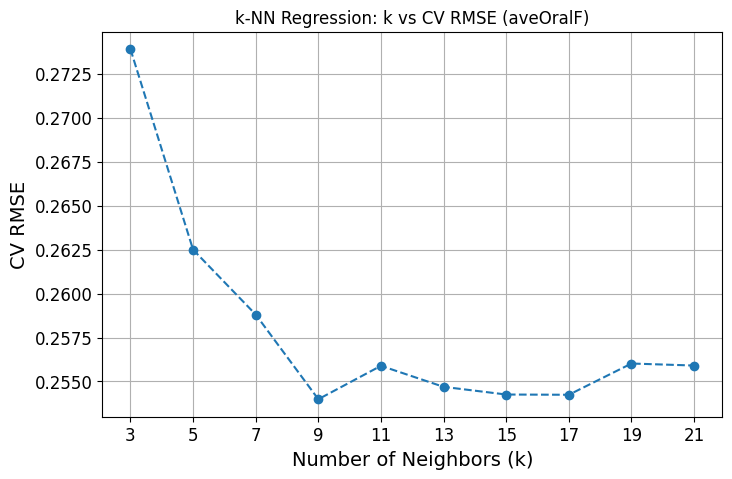

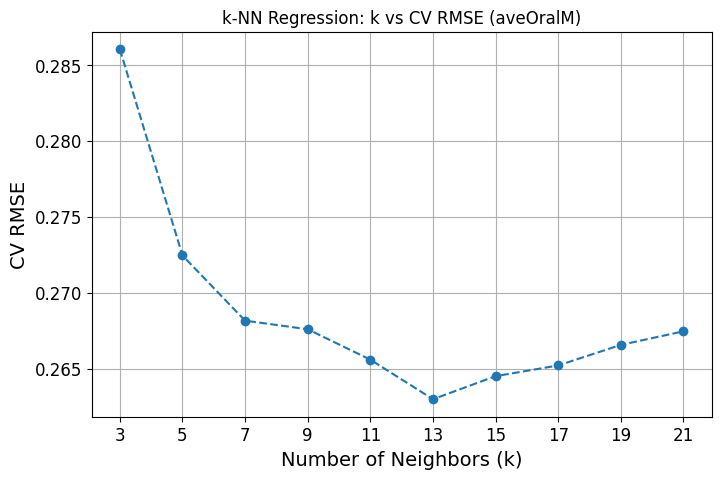

------------------------------

Test Set Evaluation:

k-NN Regression (aveOralF) Evaluation:
RMSE: 0.241
MAE: 0.171
R²: 0.639

k-NN Regression (aveOralM) Evaluation:
RMSE: 0.288
MAE: 0.206
R²: 0.720
------------------------------


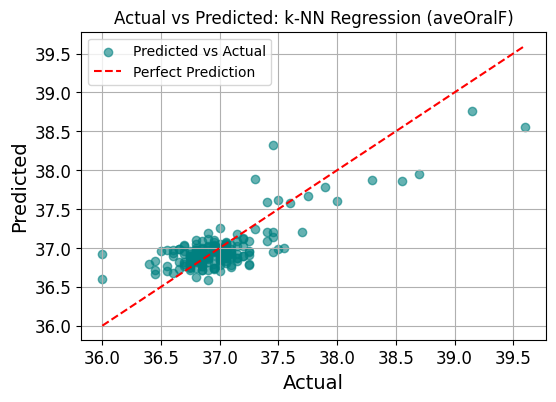

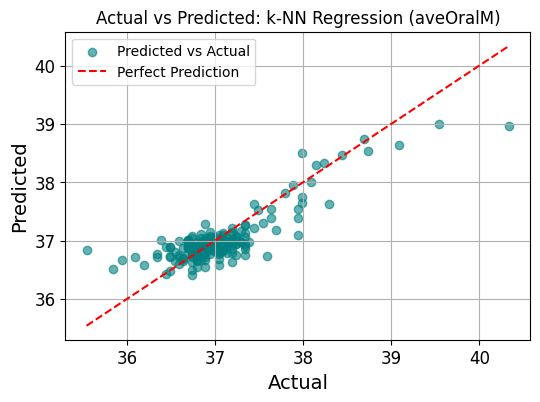

In [26]:
# Hyperparameter tuning
knn_params = {
    'n_neighbors': list(range(3, 22, 2))
}

# Helper function to tune and evaluate k-NN regression
def tune_knn(X_train, y_train, param_grid, cv=10):
    knn = KNeighborsRegressor()
    grid_search = GridSearchCV(
        knn,
        param_grid,
        scoring='neg_mean_squared_error',
        cv=cv,
        return_train_score=True
    )
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.cv_results_

# aveOralF
best_knn_f, cv_results_f = tune_knn(X_train_scaled, y_train['aveOralF'], knn_params)
# aveOralM
best_knn_m, cv_results_m = tune_knn(X_train_scaled, y_train['aveOralM'], knn_params)

# Plotting CV RMSE vs. k
def plot_knn_cv_rmse(cv_results, target_name):
    k_values = [p['n_neighbors'] for p in cv_results['params']]
    rmse_scores = [np.sqrt(-score) for score in cv_results['mean_test_score']]

    plt.figure(figsize=(8, 5))
    plt.plot(k_values, rmse_scores, marker='o', linestyle='dashed')
    plt.xticks(k_values)
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("CV RMSE")
    plt.title(f"k-NN Regression: k vs CV RMSE ({target_name})")
    plt.grid(True)
    plt.show()

# Show CV plots
print("\nk-NN CV RMSE Plots:")
plot_knn_cv_rmse(cv_results_f, "aveOralF")
plot_knn_cv_rmse(cv_results_m, "aveOralM")
print("-" * 30)

# Test Set Evaluation
print("\nTest Set Evaluation:")
y_pred_knn_f = evaluate_regression_model(
    best_knn_f, X_test_scaled, y_test['aveOralF'], model_name="k-NN Regression (aveOralF)"
)
y_pred_knn_m = evaluate_regression_model(
    best_knn_m, X_test_scaled, y_test['aveOralM'], model_name="k-NN Regression (aveOralM)"
)
print("-" * 30)

# Actual vs predicted plots
plot_actual_vs_predicted(y_test['aveOralF'], y_pred_knn_f, model_name="k-NN Regression (aveOralF)")
plot_actual_vs_predicted(y_test['aveOralM'], y_pred_knn_m, model_name="k-NN Regression (aveOralM)")


k-NN Regression offered competitive performance for `aveOralF`, with an RMSE of ~0.241 and R² ≈ 0.639, suggesting it can capture patterns relatively well without assuming a linear relationship.

However, for `aveOralM`, performance is slightly worse (R² ≈ 0.720, higher RMSE), likely due to the algorithm's sensitivity to noise and curse of dimensionality

<br>

---
<br>

## **G. SGD Regressor**

SGDRegressor Best Hyperparameters:

aveOralF -> {'eta0': 0.01, 'max_iter': 1000, 'penalty': 'l1', 'tol': 1e-05}
aveOralM -> {'eta0': 0.01, 'max_iter': 1000, 'penalty': 'l1', 'tol': 1e-05}
------------------------------

Cross-Validation RMSE:

aveOralF:
CV RMSE: 0.5412438112491663
CV RMSE (std): 0.6513708511632811

aveOralM:
CV RMSE: 0.5417332724820189
CV RMSE (std): 0.6409456199793998
------------------------------

Test Set Evaluation:

SGDRegressor (aveOralF) Evaluation:
RMSE: 0.242
MAE: 0.185
R²: 0.637

SGDRegressor (aveOralM) Evaluation:
RMSE: 0.267
MAE: 0.203
R²: 0.759
------------------------------


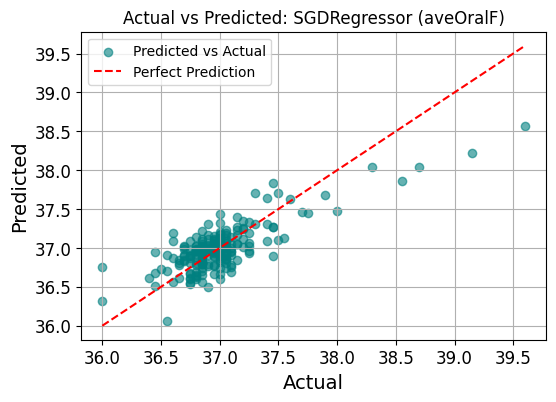

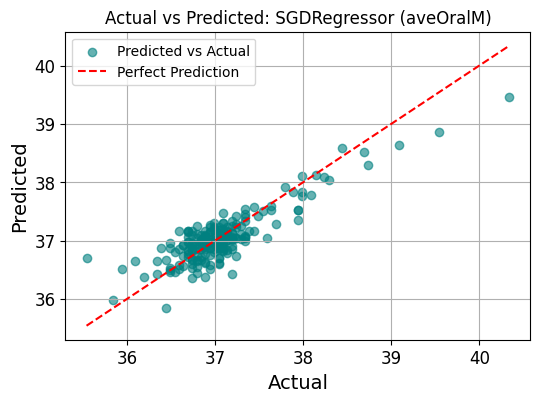

In [27]:
# Hyperparameter tuning
sgd_params = {
    'max_iter': [1000, 2000],
    'tol': [1e-3, 1e-5],
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'eta0': [0.01, 0.1]
}

# Helper function to perform GridSearchCV for SGDRegressor
def tune_sgd(X_train, y_train, param_grid, cv=10):
    sgd = SGDRegressor(random_state=SEED)
    grid_search = GridSearchCV(
        sgd,
        param_grid,
        scoring='neg_mean_squared_error',
        cv=cv,
        return_train_score=True
    )
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Perform tuning
best_sgd_f, best_params_f = tune_sgd(X_train_scaled, y_train['aveOralF'], sgd_params)
best_sgd_m, best_params_m = tune_sgd(X_train_scaled, y_train['aveOralM'], sgd_params)

# Show best hyperparameters
print("SGDRegressor Best Hyperparameters:\n")
print(f"aveOralF -> {best_params_f}")
print(f"aveOralM -> {best_params_m}")
print("-" * 30)

# Cross-validation RMSE
print("\nCross-Validation RMSE:")
print("\naveOralF:")
cross_val_rmse(best_sgd_f, X_train_scaled, y_train['aveOralF'])
print("\naveOralM:")
cross_val_rmse(best_sgd_m, X_train_scaled, y_train['aveOralM'])
print("-" * 30)

# Test Set Evaluation
print("\nTest Set Evaluation:")
y_pred_sgd_f = evaluate_regression_model(
    best_sgd_f, X_test_scaled, y_test['aveOralF'], model_name="SGDRegressor (aveOralF)"
)
y_pred_sgd_m = evaluate_regression_model(
    best_sgd_m, X_test_scaled, y_test['aveOralM'], model_name="SGDRegressor (aveOralM)"
)
print("-" * 30)

# Plot Actual vs Predicted
plot_actual_vs_predicted(y_test['aveOralF'], y_pred_sgd_f, model_name="SGDRegressor (aveOralF)")
plot_actual_vs_predicted(y_test['aveOralM'], y_pred_sgd_m, model_name="SGDRegressor (aveOralM)")

### **Feature Importance: SGD Coefficients**

Feature Importance:


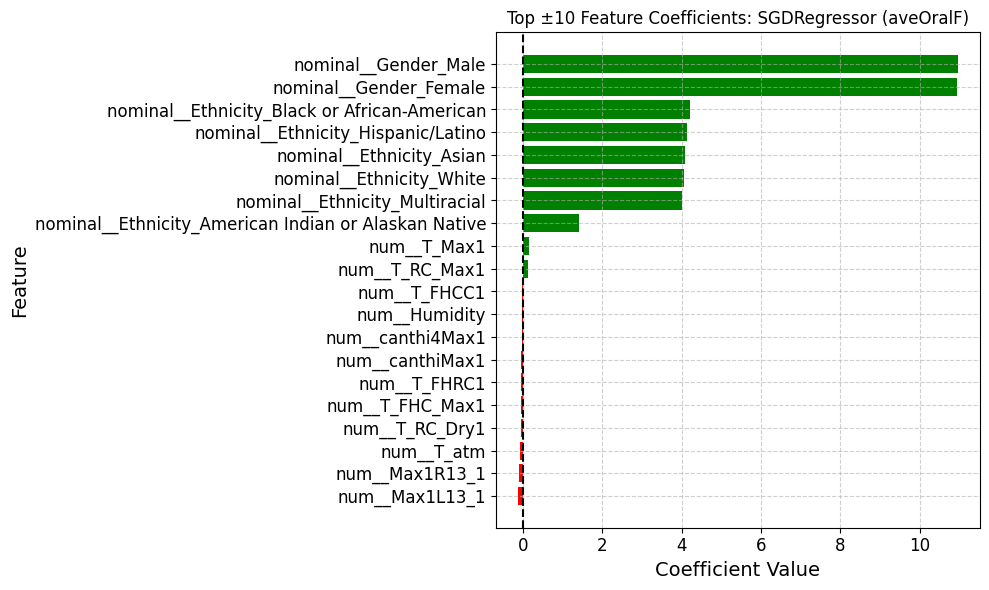

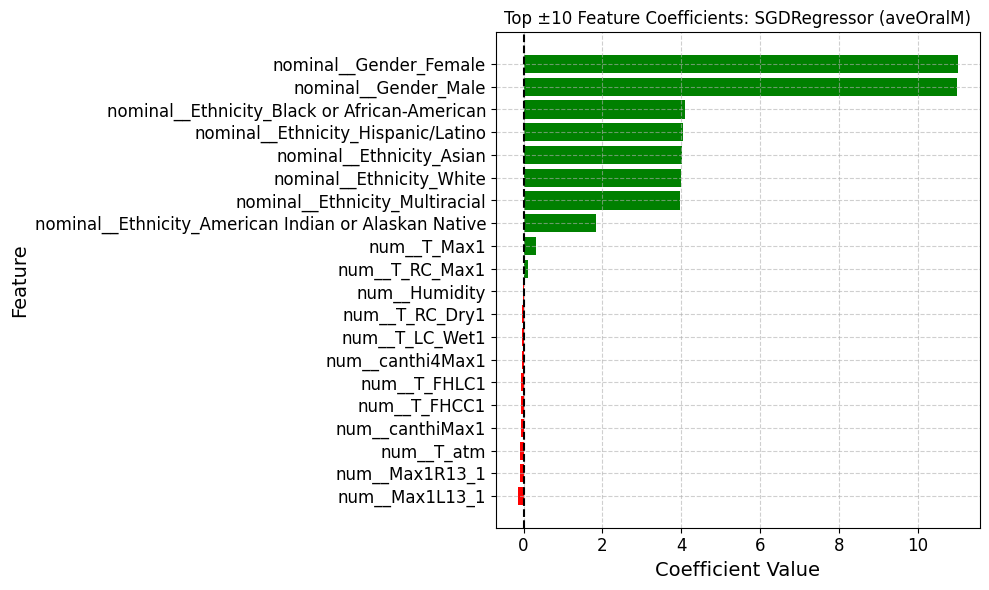

In [28]:
# Feature Importance Plots
print("Feature Importance:")
plot_feature_coefficients(best_sgd_f, preprocessor_scaled, model_name="SGDRegressor (aveOralF)", top_n=10)
plot_feature_coefficients(best_sgd_m, preprocessor_scaled, model_name="SGDRegressor (aveOralM)", top_n=10)

SGD Regressor showed more variability in cross-validation performance compared to other models, as seen in its higher CV RMSE and standard deviation. However, on the test set, it achieved competitive performance close to that of Ridge and Lasso, particularly on aveOralM (R² ≈ 0.759). This indicates that, despite its sensitivity to tuning and data fluctuations, SGD can still be a viable linear model when properly optimized.

Interestingly, demographic features such as `nominal__Gender_Male`, `nominal__Gender_Female`, and several ethnicity categories had the highest absolute coefficients in this model. This suggests that demographic attributes may be overshadowing more nuanced other features like infrared temperature readings, which might indicate bias and highlight limitations.

<br>

---
<br>

## **H. Neural Network (MLP) with Bayesian Hyperparameter Optimisation**

To explore potential non-linear relationships in the infrared thermography data, a Multi-Layer Perceptron (MLP) regressor was developed and tuned using **Bayesian optimisation**.
Given the sensitivity of neural network performance to architectural and training hyperparameters, the tuning process was conducted in two stages:

<br>

1. **Broad Bayesian Search (Exploratory Phase)**
   The initial search deliberately covered a wide hyperparameter space to map out promising regions and prevent premature narrowing. The broad search included the following ranges:
   - Hidden layers: 1–4
   - Neurons per layer: 64–512 (step 64)
   - Activation functions: "relu" or "elu"
   - Learning rate: 1e-4 → 3e-2 (log-scaled)
   - Dropout: 0.0 → 0.4 (step 0.1)

   This exploratory stage identified that the **best-performing region** consistently involved:

   - deeper architectures (3–4 layers),
   - wider layers (≈256 units),
   - ELU activation,
   - moderately small learning rates (around 0.002–0.006),
   - minimal or no dropout.

<br>

2. **Refined Bayesian Search (Focused Phase)**
   Based on these findings, a second, narrower Bayesian search around the optimal region is conducted below with restricted ranges to:

   - Hidden layers: 3–5
   - Neurons per layer: 192–320 (step 32)
   - Activation: "elu"
   - Learning rate: 2e-3 → 8e-3
   - Dropout: 0.00 → 0.10 (step 0.05)

MLP Best Hyperparameters (refined deterministic search):

aveOralF: {'n_hidden': 4, 'n_neurons': 320, 'activation': 'elu', 'learning_rate': 0.0023942369386621156, 'dropout_rate': 0.05}
aveOralM: {'n_hidden': 4, 'n_neurons': 256, 'activation': 'elu', 'learning_rate': 0.003986363135122741, 'dropout_rate': 0.0}
------------------------------

Test Set Evaluation:

MLP Regression (aveOralF):
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

MLP Regression (aveOralF) Evaluation:
RMSE: 0.230
MAE: 0.172
R²: 0.671

MLP Regression (aveOralM):
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

MLP Regression (aveOralM) Evaluation:
RMSE: 0.257
MAE: 0.196
R²: 0.777


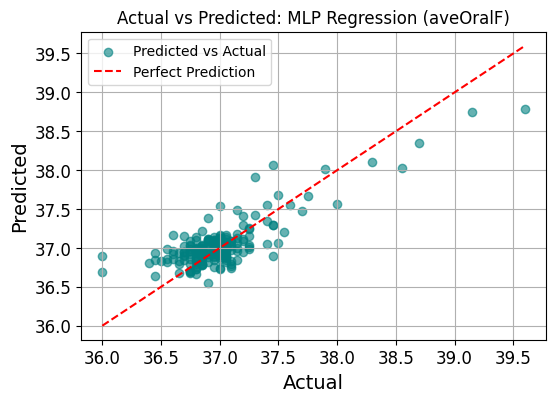

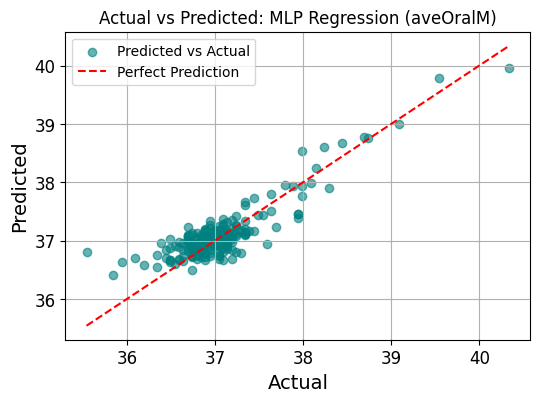

In [29]:
# Data Preparation for MLP

from sklearn.model_selection import train_test_split
import numpy as np
import keras_tuner as kt
from tensorflow import keras

# Train/val split for each target
X_train_nn_F, X_val_nn_F, y_train_nn_F, y_val_nn_F = train_test_split(
    X_train_scaled, y_train["aveOralF"], test_size=0.2, random_state=SEED
)

X_train_nn_M, X_val_nn_M, y_train_nn_M, y_val_nn_M = train_test_split(
    X_train_scaled, y_train["aveOralM"], test_size=0.2, random_state=SEED
)

# Convert to float32 (Keras requirement)
def to_float32(*arrays):
    return [np.asarray(a).astype(np.float32) for a in arrays]

X_train_nn_F, X_val_nn_F, X_train_nn_M, X_val_nn_M = to_float32(
    X_train_nn_F, X_val_nn_F, X_train_nn_M, X_val_nn_M
)
X_test_nn = np.asarray(X_test_scaled).astype(np.float32)

y_train_nn_F, y_val_nn_F = to_float32(y_train_nn_F, y_val_nn_F)
y_train_nn_M, y_val_nn_M = to_float32(y_train_nn_M, y_val_nn_M)
y_test_F = np.asarray(y_test["aveOralF"]).astype(np.float32)
y_test_M = np.asarray(y_test["aveOralM"]).astype(np.float32)


# Refined-search MLP

def build_mlp(hp, input_shape):
    n_hidden = hp.Int("n_hidden", min_value=3, max_value=5, step=1)
    n_neurons = hp.Int("n_neurons", min_value=192, max_value=320, step=32)
    activation = hp.Choice("activation", values=["elu"])
    learning_rate = hp.Float(
        "learning_rate",
        min_value=2e-3,
        max_value=8e-3,
        sampling="log",
    )
    dropout_rate = hp.Float(
        "dropout_rate",
        min_value=0.0,
        max_value=0.1,
        step=0.05,
    )

    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=input_shape))

    for _ in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=activation))
        if dropout_rate > 0:
            model.add(keras.layers.Dropout(dropout_rate))

    model.add(keras.layers.Dense(1))

    model.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["mae"],
    )
    return model


# Tuner wrapper

def run_tuner(X_train, y_train, X_val, y_val, project_name):
    tuner = kt.BayesianOptimization(
        hypermodel=lambda hp: build_mlp(hp, input_shape=X_train.shape[1:]),
        objective="val_loss",
        max_trials=40,
        num_initial_points=8,
        directory="mlp_tuning_deterministic",
        project_name=project_name,
        overwrite=True,
        seed=SEED,
    )

    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        restore_best_weights=True,
    )

    tuner.search(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0,
    )

    best_model = tuner.get_best_models(1)[0]
    best_hp = tuner.get_best_hyperparameters(1)[0]
    return best_model, best_hp


# Run tuning for both targets

best_mlp_f, best_hp_f = run_tuner(
    X_train_nn_F, y_train_nn_F, X_val_nn_F, y_val_nn_F, project_name="mlp_aveOralF_refined"
)
best_mlp_m, best_hp_m = run_tuner(
    X_train_nn_M, y_train_nn_M, X_val_nn_M, y_val_nn_M, project_name="mlp_aveOralM_refined"
)

print("MLP Best Hyperparameters (refined deterministic search):\n")
print("aveOralF:", best_hp_f.values)
print("aveOralM:", best_hp_m.values)
print("-" * 30)


# Test Set Evaluation

print("\nTest Set Evaluation:")
y_pred_mlp_f = best_mlp_f.predict(X_test_nn, verbose=0).flatten()
y_pred_mlp_m = best_mlp_m.predict(X_test_nn, verbose=0).flatten()


print("\nMLP Regression (aveOralF):")
evaluate_regression_model(
    best_mlp_f, X_test_nn, y_test_F, model_name="MLP Regression (aveOralF)"
)

print("\nMLP Regression (aveOralM):")
evaluate_regression_model(
    best_mlp_m, X_test_nn, y_test_M, model_name="MLP Regression (aveOralM)"
)

# Plot Actual vs Predicted
plot_actual_vs_predicted(y_test_F, y_pred_mlp_f, model_name="MLP Regression (aveOralF)")
plot_actual_vs_predicted(y_test_M, y_pred_mlp_m, model_name="MLP Regression (aveOralM)")


For **aveOralF**, the refined deterministic MLP Regressor achieved an R² of ≈0.671 with RMSE ≈0.230 and MAE ≈0.172, slightly outperforming the regularised linear models (R² ≈0.656, RMSE ≈0.236).

For **aveOralM**, the MLP reached an R² of ≈0.777 with RMSE ≈0.257 and MAE ≈0.196, which **slightly exceeds** the strongest linear models (R² ≈0.762, RMSE ≈0.266). The improvement is more modest here, reflecting that monitor-mode readings are already highly linear and stable due to reduced noise. Still, the MLP demonstrates a measurable advantage in capturing small non-linear effects.

These slight improvements across both targets suggest that the MLP is able to model subtle non-linear relationships in the infrared features that linear models cannot fully capture.


<br>

---
<br>

## **Regression Model Comparison**

This workflow evaluated a range of regression models to predict oral temperature from infrared thermography features in both fast mode `aveOralF` and monitor mode `aveOralM`. The models were assessed using standard metrics: R², RMSE, and MAE, on a stratified test set after rigorous preprocessing and cross-validation.

<br>

### **Performance on aveOralF (fast mode)**

Fast-mode oral temperature (aveOralF) is the noisier and more variable target due to shorter acquisition time and fewer averaged readings. This makes prediction more challenging and amplifies the value of models capable of capturing non-linear structure.

Regression Test Metrics – aveOralF


R2   RMSE    MAE
Linear Regression  0.645  0.239  0.182
Ridge              0.656  0.236  0.175
Lasso              0.655  0.236  0.178
Elastic Net        0.656  0.236  0.177
Polynomial         0.581  0.260  0.197
kNN                0.639  0.241  0.171
SGDRegressor       0.637  0.242  0.185
MLP                0.671  0.230  0.172

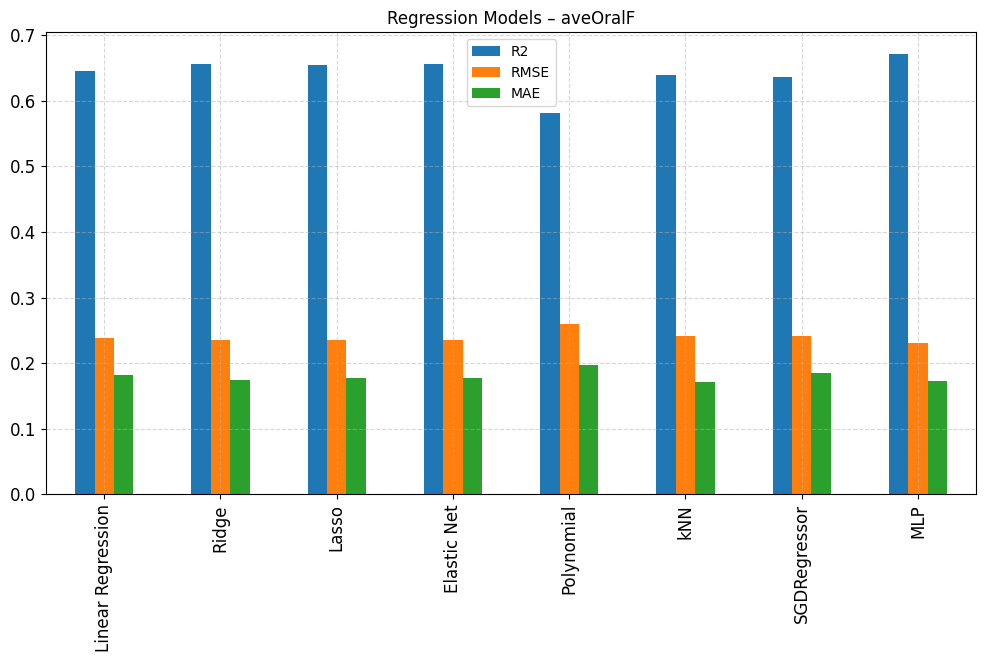

In [30]:
models_F = {
    "Linear Regression": lin_reg,
    "Ridge": best_ridge_f,
    "Lasso": best_lasso_f,
    "Elastic Net": best_elastic_f,
    "Polynomial": best_poly_f,
    "kNN": best_knn_f,
    "SGDRegressor": best_sgd_f,
    "MLP": best_mlp_f
}

table_F = pd.DataFrame({
    name: get_regression_metrics(model, X_test_scaled, y_test["aveOralF"])
    for name, model in models_F.items()
}).T

print("Regression Test Metrics – aveOralF")
table_F = table_F.round(3)
display(table_F)

table_F.plot(kind="bar", figsize=(12, 6), title="Regression Models – aveOralF")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

Across the tested models,**Ridge** and **Lasso Regression** performed well (R² ≈ 0.655), highlighting that much of the predictive relationship is linear.
However, the **MLP achieved the highest performance**, with:

- R² ≈ 0.671
- RMSE ≈ 0.230
- MAE ≈ 0.172

This improvement suggests that fast-mode readings contain additional non-linear structure not fully captured by linear models, which the neural network can exploit, particularly after refined deterministic hyperparameter tuning.

Polynomial Regression and k-NN did not surpass the baselines, likely due to overfitting (Polynomial) or sensitivity to high-dimensional data (k-NN).

SGD Regressor performed reasonably well but showed more variability.

### **Performance on aveOralM (monitor mode)**

Monitor-mode oral temperature (aveOralM) is a **much more stable and less noisy** target due to its longer averaging window, which explains the generally higher R² values across all models.


Regression Test Metrics – aveOralM


R2   RMSE    MAE
Linear Regression  0.759  0.267  0.204
Ridge              0.762  0.266  0.201
Lasso              0.763  0.265  0.200
Elastic Net        0.762  0.265  0.200
Polynomial         0.711  0.293  0.229
kNN                0.720  0.288  0.206
SGDRegressor       0.759  0.267  0.203
MLP                0.777  0.257  0.196

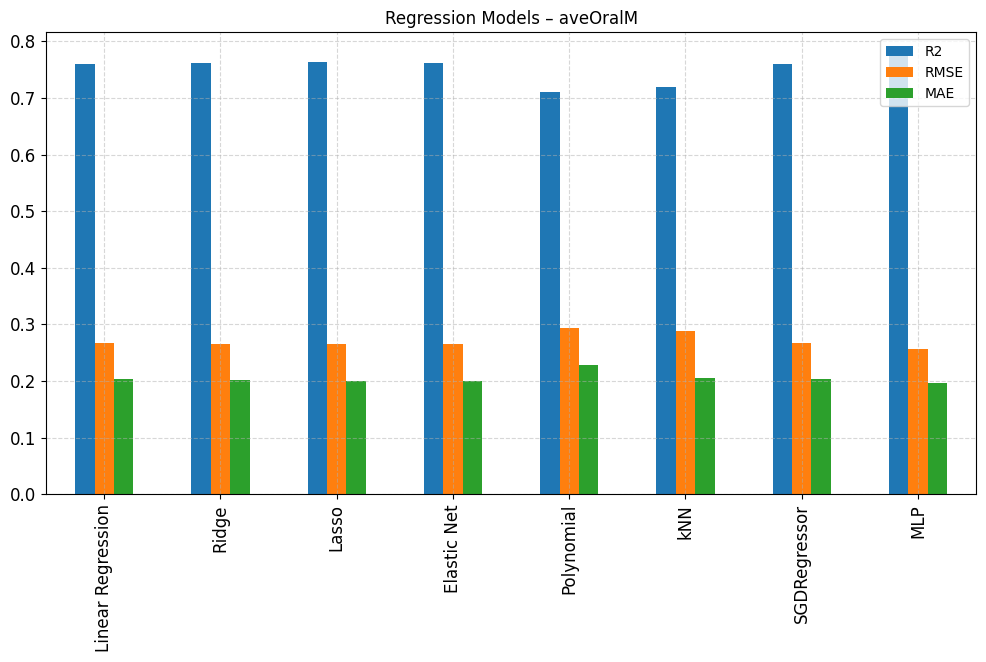

In [31]:
models_M = {
    "Linear Regression": lin_reg_m,
    "Ridge": best_ridge_m,
    "Lasso": best_lasso_m,
    "Elastic Net": best_elastic_m,
    "Polynomial": best_poly_m,
    "kNN": best_knn_m,
    "SGDRegressor": best_sgd_m,
    "MLP": best_mlp_m
}

table_M = pd.DataFrame({
    name: get_regression_metrics(model, X_test_scaled, y_test["aveOralM"])
    for name, model in models_M.items()
}).T

print("\nRegression Test Metrics – aveOralM")
table_M = table_M.round(3)
display(table_M)

table_M.plot(kind="bar", figsize=(12, 6), title="Regression Models – aveOralM")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

**Linear models** (Linear Regression, Ridge, Lasso, Elastic Net) remained strong, with Ridge and Lasso reaching:
- R² ≈ 0.761–0.763
- RMSE ≈ 0.265
- MAE ≈ 0.200

These results suggest that the relationship between monitor-mode oral temperature and the infrared and contextual features is **largely linear**.

The refined deterministic MLP achieved:
- R² ≈ 0.777
- RMSE ≈ 0.257
- MAE ≈ 0.196

This places the **MLP above all linear baselines**, though the improvement is **modest**. Differences are small enough that they might not be clinically meaningful. Simpler models (Ridge/Lasso) may still be preferable in deployment due to interpretability and training cost.

Other approaches like Polynomial Regression and k-NN again underperformed compared to the linear models, and SGDRegressor matched Linear Regression but did not surpass the regularised baselines.

<br>

The systematically higher R² scores for **aveOralM** (monitor mode) compared to **aveOralF** (fast mode) are consistent with the underlying measurement protocol: monitor mode averages more readings over time, producing a less noisy and more stable target. This makes aveOralM inherently easier to predict from the infrared features.

<br>
<br>
<br>

---
---
<br>
<br>

# **Classification Task**
The goal is to predict whether a person has a **fever (≥ 37.5°C)** based on infrared features. This is a **binary classification task** with **imbalanced labels**, particularly for **feverF (only ~6% positives)**, which strongly impacts model choice and evaluation strategy.

All classification models are trained and evaluated on the **same stratified train/test split** created using **feverF as the stratification label**. Because the two oral measurements are highly correlated, this split preserves a realistic class distribution for both feverF and feverM.

To support proper **threshold tuning** and prevent **test-set leakage**, an **internal validation split (20%)** is created **only for the classification workflow**. This validation set is used to:

- **compare models on equal terms**,

- **perform threshold optimisation for F1-score**,

- **select the best classifier per target**.

Due to the **class imbalance** (low fever rate), **accuracy is misleading**, thus F1-score, precision, recall, and ROC-AUC are used to assess the models. However, the **F1-score** is used as the **main metric** to balance between **false negatives** (missing a fever) and **false positives**. In **medical contexts**, both are important to control.



### **Setup & Utility Functions (Classification)**

Unless stated otherwise, all classifiers use the **default decision threshold of 0.50**: the positive class (fever = 1) is predicted when the estimated probability `P(y=1 | x)` is at least 0.5. Threshold tuning later explicitly searches for alternative cut-offs that maximise F1 on the validation set.


In [32]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    auc,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_curve,
)

# An internal validation set ONLY for classification tasks
X_train_clf, X_val_clf, y_train_clf, y_val_clf = train_test_split(
    X_train_scaled,
    y_train[["feverF", "feverM"]],
    test_size=0.2,
    stratify=y_train["feverF"],  # keeping feverF imbalance consistent
    random_state=SEED
)

# Targets for classification
y_train_feverF = y_train_clf["feverF"]
y_val_feverF   = y_val_clf["feverF"]
y_train_feverM = y_train_clf["feverM"]
y_val_feverM   = y_val_clf["feverM"]

# Test labels
y_test_feverF = y_test["feverF"]
y_test_feverM = y_test["feverM"]

# Helper function to evaluate model performance
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
    print(f"F1 Score:  {f1_score(y_test, y_pred):.3f}")
    print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.3f}")


# Helper function to plot Precision-Recall and ROC curves
def plot_precision_recall_roc_curves(model, X_test, y_test, model_name):
    y_scores = model.predict_proba(X_test)[:, 1]

    precisions, recalls, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recalls, precisions)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # PR Curve
    plt.figure(figsize=(6, 4))
    plt.plot(recalls, precisions, label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve: {model_name}")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ROC Curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"ROC Curve: {model_name}")
    plt.grid(True)
    plt.legend()
    plt.show()


# Helper function to find optimal threshold
def find_optimal_threshold(model, X_val, y_val):
    y_scores = model.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0.1, 0.9, 81)
    f1_scores = [(f1 := f1_score(y_val, (y_scores >= t).astype(int))) for t in thresholds]

    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]

    print(f"Optimal Threshold: {best_threshold:.2f} | Max F1 Score: {f1_scores[best_index]:.4f}")
    return best_threshold


# Helper function to re-evaluate performance after threshold tuning
def evaluate_with_custom_threshold(model, X_test, y_test, threshold, model_name):
    y_scores = model.predict_proba(X_test)[:, 1]
    y_pred_thresh = (y_scores >= threshold).astype(int)

    print(f"\n{model_name} Evaluation with Threshold {threshold:.2f}:")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred_thresh):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred_thresh):.3f}")
    print(f"Recall:    {recall_score(y_test, y_pred_thresh):.3f}")
    print(f"F1 Score:  {f1_score(y_test, y_pred_thresh):.3f}")


    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_thresh))
    disp.plot()
    plt.title(f"Confusion Matrix (Threshold {threshold:.2f}): {model_name}")
    plt.show()


The same validation split (X_val_clf, y_val_clf) is reused for **all classification models** (Logistic Regression, SGD, MLP, and Random Forest). This ensures a fair comparison: each model is tuned and threshold-optimised on exactly the same data, while the held-out test set remains untouched until the final evaluation.

<br>
<br>
    
    
---
<br>

## **A. Logistic Regression**

In [33]:
def tune_and_evaluate_logreg(X_train, X_val, y_train, y_val, target_label):
    print(f"\nLogistic Regression: {target_label}")

    # Grid Search
    log_reg = LogisticRegression(class_weight='balanced', random_state=SEED, max_iter=6000)
    param_grid = {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }

    # Hyperparameter tuning (with CV)
    grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_logreg = grid_search.best_estimator_
    print(f"Best Params for {target_label}: {grid_search.best_params_}")

    # Evaluate on VALIDATION set with default threshold (0.5)
    evaluate_model(best_logreg, X_val, y_val, f"Logistic Regression (val) - {target_label}")

    # Plot PR and ROC curves
    plot_precision_recall_roc_curves(best_logreg, X_val, y_val, f"Logistic Regression (val) - {target_label}")

    # Tune threshold on VALIDATION based on F1
    print(f"\nThreshold tuning for Logistic Regression (val) - {target_label}")
    best_threshold = find_optimal_threshold(best_logreg, X_val, y_val)

    # Re-evaluate with optimal threshold on VALIDATION
    evaluate_with_custom_threshold(best_logreg, X_val, y_val, best_threshold, f"Logistic Regression (val, thresh) - {target_label}")

    # F1 on validation at tuned threshold (used for model comparison)
    y_scores_val = best_logreg.predict_proba(X_val)[:, 1]
    y_pred_val_thresh = (y_scores_val >= best_threshold).astype(int)
    f1_at_thresh_val = f1_score(y_val, y_pred_val_thresh)

    return best_logreg, best_threshold, f1_at_thresh_val


Logistic Regression: feverF
Best Params for feverF: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

Logistic Regression (val) - feverF Evaluation:
Accuracy:  0.982
Precision: 0.818
Recall:    0.900
F1 Score:  0.857
ROC AUC:   0.910


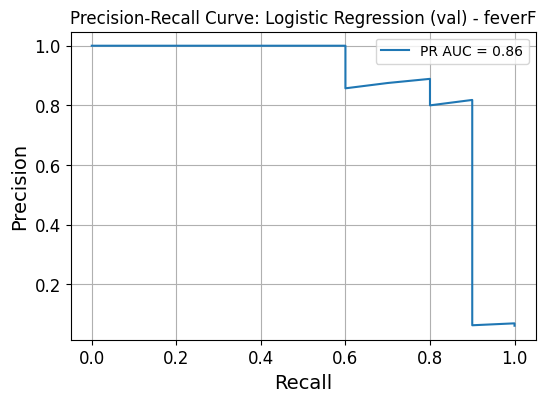

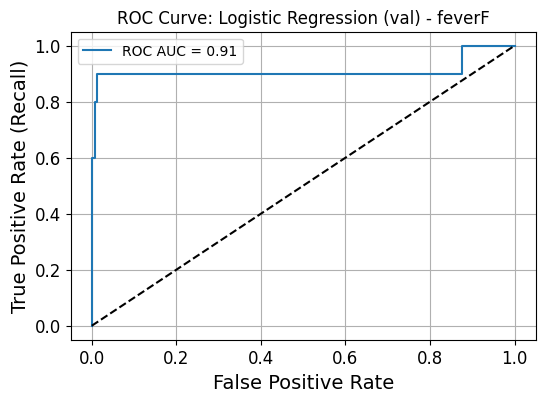


Threshold tuning for Logistic Regression (val) - feverF
Optimal Threshold: 0.42 | Max F1 Score: 0.8571

Logistic Regression (val, thresh) - feverF Evaluation with Threshold 0.42:
Accuracy:  0.982
Precision: 0.818
Recall:    0.900
F1 Score:  0.857


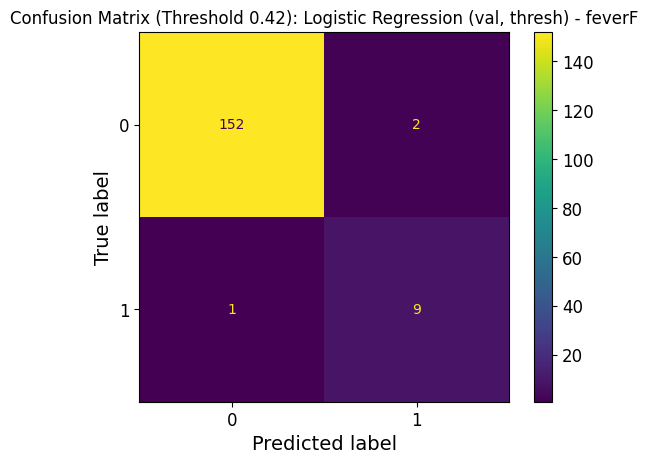

--------------------------------------------------------------------------------


Logistic Regression: feverM
Best Params for feverM: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}

Logistic Regression (val) - feverM Evaluation:
Accuracy:  0.939
Precision: 0.600
Recall:    0.857
F1 Score:  0.706
ROC AUC:   0.975


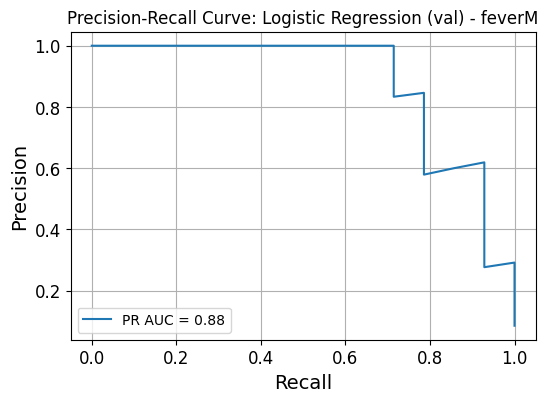

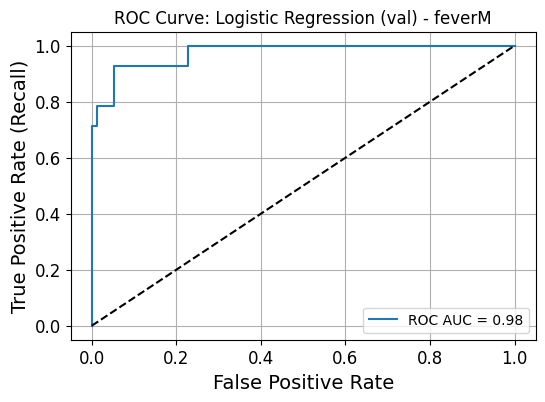


Threshold tuning for Logistic Regression (val) - feverM
Optimal Threshold: 0.62 | Max F1 Score: 0.8333

Logistic Regression (val, thresh) - feverM Evaluation with Threshold 0.62:
Accuracy:  0.976
Precision: 1.000
Recall:    0.714
F1 Score:  0.833


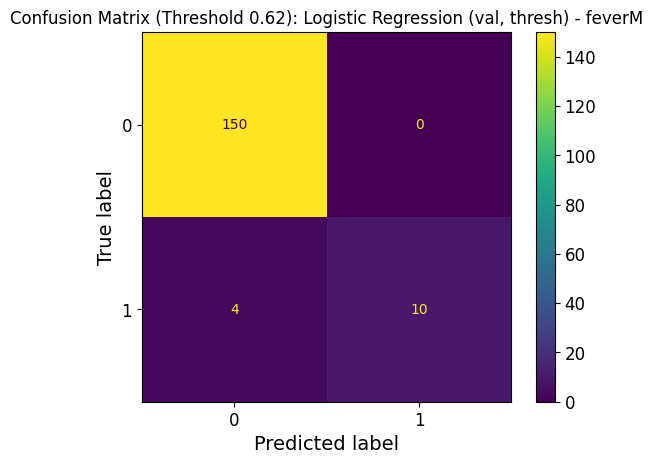

In [34]:
best_logreg_feverF, thresh_logreg_feverF, f1_logreg_feverF = tune_and_evaluate_logreg(
    X_train_clf, X_val_clf, y_train_feverF, y_val_feverF, "feverF"
)

print('-' * 80 + '\n')

best_logreg_feverM, thresh_logreg_feverM, f1_logreg_feverM = tune_and_evaluate_logreg(
    X_train_clf, X_val_clf, y_train_feverM, y_val_feverM, "feverM"
)


For `feverF`, Logistic Regression with class-balancing and L1 penalty achieved an F1-score of ≈0.857 on the validation set after threshold tuning (threshold ≈0.42), with high ROC-AUC (≈0.910).

For `feverM`, the tuned model reached an F1-score of ≈0.833 at threshold ≈0.62 and ROC-AUC ≈0.975, indicating strong discriminative performance despite the imbalance.

<br>
<br>

---
<br>

## **B. SGD Classifier**

In [35]:
def tune_and_evaluate_sgd(X_train, X_val, y_train, y_val, target_label):
    print(f"\nSGD Classifier: {target_label}")

    # Grid Search
    sgd = SGDClassifier(class_weight="balanced", random_state=SEED)
    param_grid = {
        "alpha": [0.0001, 0.001, 0.01],
        "penalty": ["l1", "l2", "elasticnet"],
        "loss": ["log_loss"],
        "tol": [1e-3],
        "max_iter": [3000],
    }

    grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring="f1", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_sgd = grid_search.best_estimator_
    print(f"Best Params for {target_label}: {grid_search.best_params_}")

    # Validation evaluation at default threshold
    evaluate_model(best_sgd, X_val, y_val, f"SGD Classifier (val) - {target_label}")

    # PR and ROC curves
    plot_precision_recall_roc_curves(best_sgd, X_val, y_val, f"SGD Classifier (val) - {target_label}")

    # Threshold tuning on validation
    print(f"\nThreshold tuning for SGD Classifier (val) - {target_label}")
    best_threshold = find_optimal_threshold(best_sgd, X_val, y_val)

    evaluate_with_custom_threshold(
        best_sgd, X_val, y_val, best_threshold,
        f"SGD Classifier (val, thresh) - {target_label}"
    )

    # F1 on validation at tuned threshold
    y_scores_val = best_sgd.predict_proba(X_val)[:, 1]
    y_pred_val_thresh = (y_scores_val >= best_threshold).astype(int)
    f1_at_thresh_val = f1_score(y_val, y_pred_val_thresh)

    return best_sgd, best_threshold, f1_at_thresh_val


SGD Classifier: feverF
Best Params for feverF: {'alpha': 0.01, 'loss': 'log_loss', 'max_iter': 3000, 'penalty': 'elasticnet', 'tol': 0.001}

SGD Classifier (val) - feverF Evaluation:
Accuracy:  0.976
Precision: 0.750
Recall:    0.900
F1 Score:  0.818
ROC AUC:   0.959


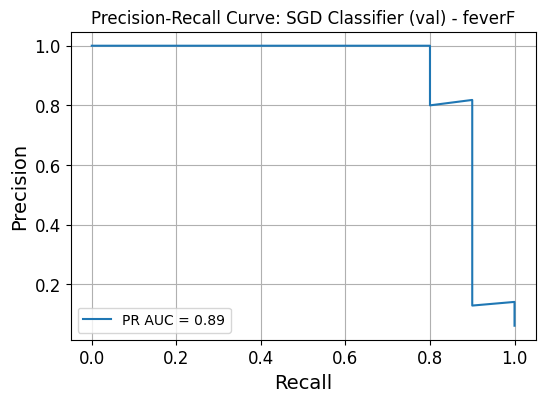

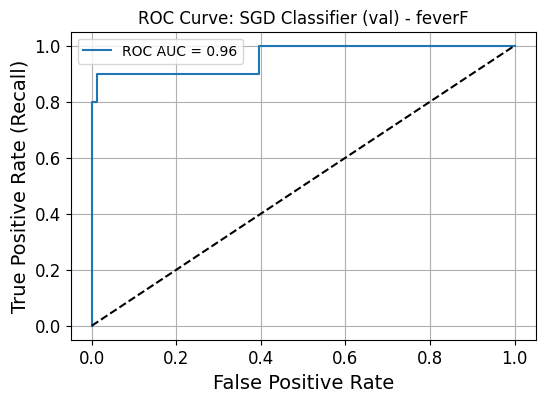


Threshold tuning for SGD Classifier (val) - feverF
Optimal Threshold: 0.84 | Max F1 Score: 0.8889

SGD Classifier (val, thresh) - feverF Evaluation with Threshold 0.84:
Accuracy:  0.988
Precision: 1.000
Recall:    0.800
F1 Score:  0.889


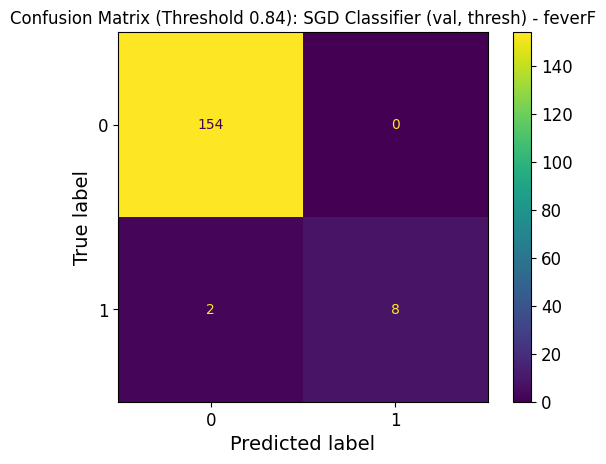

--------------------------------------------------------------------------------


SGD Classifier: feverM
Best Params for feverM: {'alpha': 0.01, 'loss': 'log_loss', 'max_iter': 3000, 'penalty': 'l1', 'tol': 0.001}

SGD Classifier (val) - feverM Evaluation:
Accuracy:  0.963
Precision: 0.750
Recall:    0.857
F1 Score:  0.800
ROC AUC:   0.982


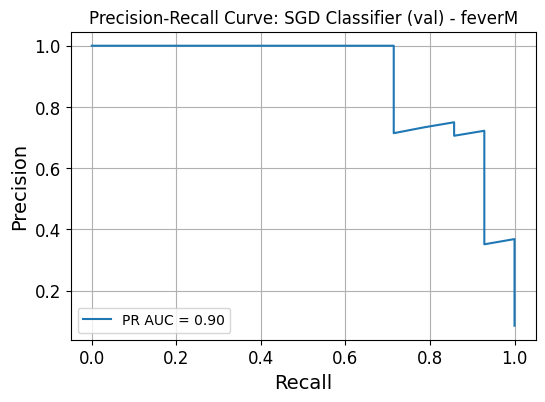

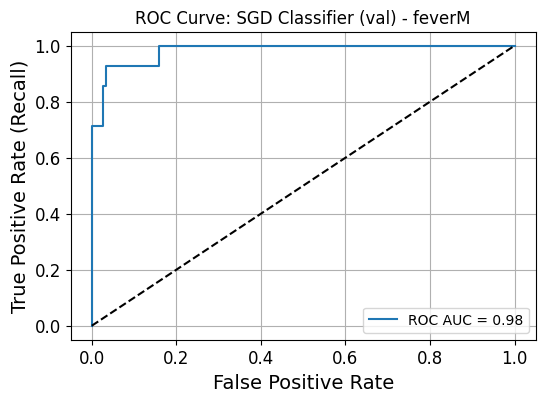


Threshold tuning for SGD Classifier (val) - feverM
Optimal Threshold: 0.86 | Max F1 Score: 0.8333

SGD Classifier (val, thresh) - feverM Evaluation with Threshold 0.86:
Accuracy:  0.976
Precision: 1.000
Recall:    0.714
F1 Score:  0.833


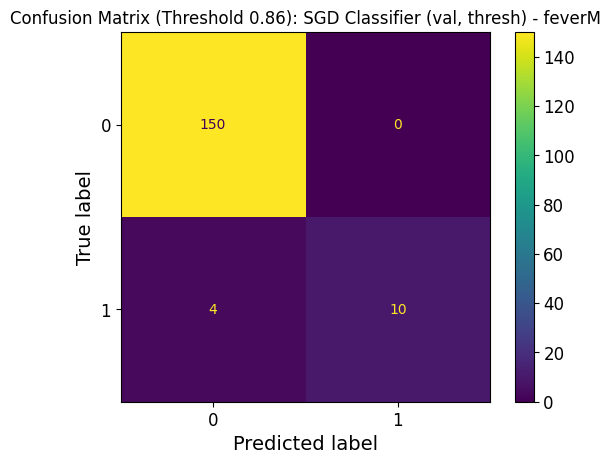

In [36]:
best_sgd_feverF, thresh_sgd_feverF, f1_sgd_feverF = tune_and_evaluate_sgd(
    X_train_clf, X_val_clf, y_train_feverF, y_val_feverF, "feverF"
)
print('-' * 80 + '\n')

best_sgd_feverM, thresh_sgd_feverM, f1_sgd_feverM = tune_and_evaluate_sgd(
    X_train_clf, X_val_clf, y_train_feverM, y_val_feverM, "feverM"
)

The SGD Classifier achieved an F1-score of ≈0.889 for `feverF` (optimal threshold ≈0.84) and ≈0.833 for `feverM` (optimal threshold ≈0.86). Its performance is close to Logistic Regression but slightly below Random Forest for `feverF`. Overall, it remains a lightweight and online-friendly alternative, though somewhat more sensitive to hyperparameters.

<br>
<br>

---
<br>

## **C. MLP Classifier**

In [37]:
# feverF specific best configs to explore
mlp_param_grid_feverF = {
    "hidden_layer_sizes": [(50,), (64,), (64, 64)],
    "activation": ["tanh"],
    "alpha": [1e-5, 1e-4],
    "learning_rate": ["constant"],
    "solver": ["adam"],
    "early_stopping": [True],
    "max_iter": [3000]
}

# feverM specific best configs to explore
mlp_param_grid_feverM = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50), (100, 100), (128, 64)],
    "alpha": [1e-5, 1e-4, 0.001],
    "activation": ["relu"],
    "solver": ["adam"],
    "learning_rate": ["constant"],
    "early_stopping": [True, False],
    "max_iter": [3000]
}

def tune_and_evaluate_mlp(X_train, X_val, y_train, y_val, target_label, param_grid):
    print(f"\nMLP Classifier: {target_label}")

    mlp = MLPClassifier(random_state=SEED)
    grid_search = GridSearchCV(
        mlp,
        param_grid,
        cv=5,
        scoring="f1",
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    best_mlp = grid_search.best_estimator_
    print(f"Best Params for {target_label}: {grid_search.best_params_}")

    # Validation default threshold evaluation
    evaluate_model(best_mlp, X_val, y_val, f"MLP Classifier ({target_label})")

    # PR and ROC curve plots
    plot_precision_recall_roc_curves(best_mlp, X_val, y_val, f"MLP Classifier (val) - {target_label}")

    # Threshold tuning on validation
    print(f"\nThreshold tuning for MLP Classifier (val) - {target_label}")
    best_threshold = find_optimal_threshold(best_mlp, X_val, y_val)

    evaluate_with_custom_threshold(best_mlp, X_val, y_val, best_threshold, f"MLP Classifier (val, thresh) - {target_label}")

    y_scores_val = best_mlp.predict_proba(X_val)[:, 1]
    y_pred_val_thresh = (y_scores_val >= best_threshold).astype(int)
    f1_at_thresh_val = f1_score(y_val, y_pred_val_thresh)

    return best_mlp, best_threshold, f1_at_thresh_val


MLP Classifier: feverF
Best Params for feverF: {'activation': 'tanh', 'alpha': 1e-05, 'early_stopping': True, 'hidden_layer_sizes': (64,), 'learning_rate': 'constant', 'max_iter': 3000, 'solver': 'adam'}

MLP Classifier (feverF) Evaluation:
Accuracy:  0.957
Precision: 0.636
Recall:    0.700
F1 Score:  0.667
ROC AUC:   0.953


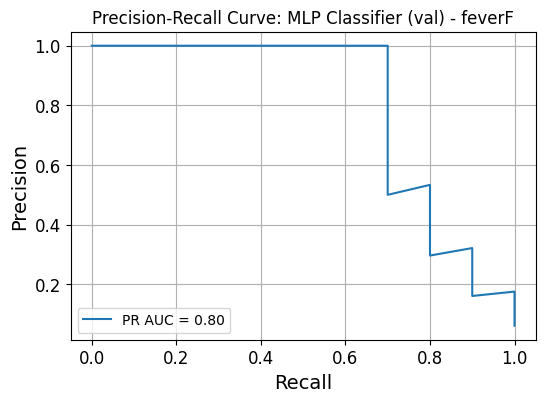

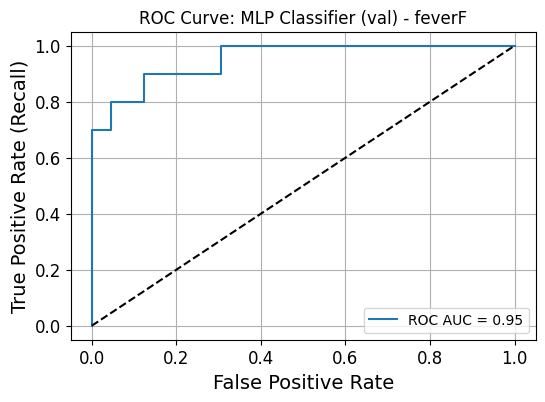


Threshold tuning for MLP Classifier (val) - feverF
Optimal Threshold: 0.54 | Max F1 Score: 0.8235

MLP Classifier (val, thresh) - feverF Evaluation with Threshold 0.54:
Accuracy:  0.982
Precision: 1.000
Recall:    0.700
F1 Score:  0.824


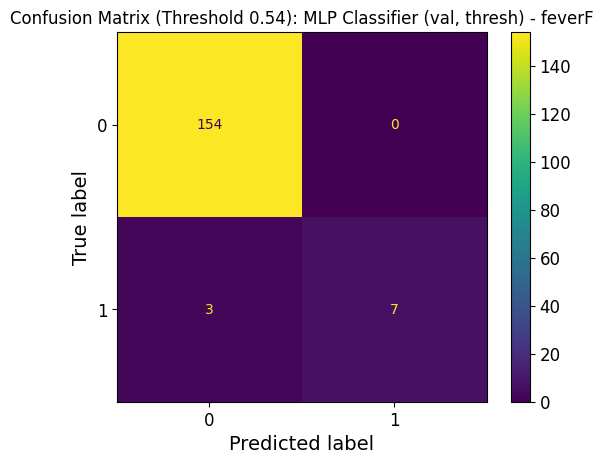

--------------------------------------------------------------------------------


MLP Classifier: feverM
Best Params for feverM: {'activation': 'relu', 'alpha': 1e-05, 'early_stopping': True, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 3000, 'solver': 'adam'}

MLP Classifier (feverM) Evaluation:
Accuracy:  0.957
Precision: 0.889
Recall:    0.571
F1 Score:  0.696
ROC AUC:   0.953


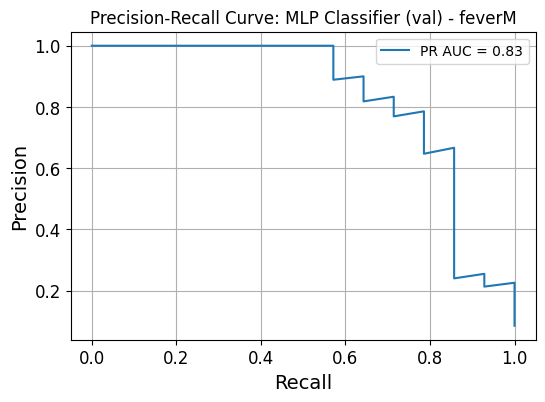

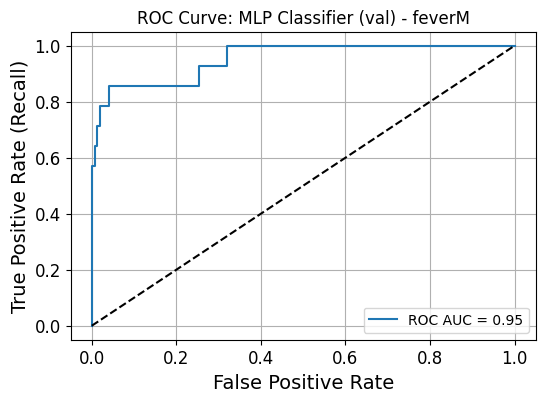


Threshold tuning for MLP Classifier (val) - feverM
Optimal Threshold: 0.44 | Max F1 Score: 0.7692

MLP Classifier (val, thresh) - feverM Evaluation with Threshold 0.44:
Accuracy:  0.963
Precision: 0.833
Recall:    0.714
F1 Score:  0.769


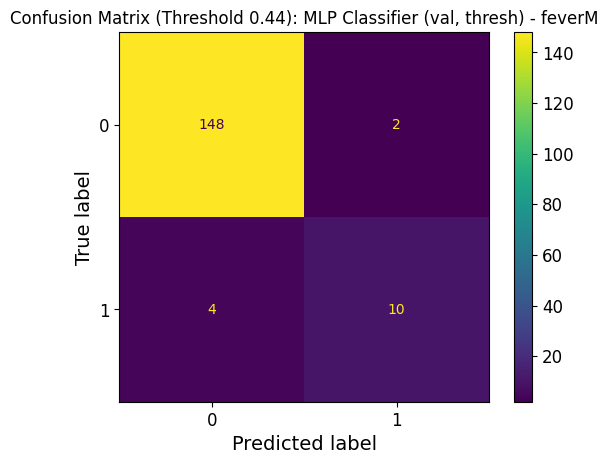

In [38]:
# Train & get best MLP model for feverF
best_mlp_model_feverF, best_threshold_mlp_feverF, f1_mlp_feverF = tune_and_evaluate_mlp(
    X_train_clf, X_val_clf, y_train_feverF, y_val_feverF, "feverF", mlp_param_grid_feverF
)

print('-' * 80 + '\n')

# Train & get best Random Forest model for feverM
best_mlp_model_feverM, best_threshold_mlp_feverM, f1_mlp_feverM = tune_and_evaluate_mlp(
    X_train_clf, X_val_clf, y_train_feverM, y_val_feverM, "feverM", mlp_param_grid_feverM
)

The MLP Classifier achieved validation F1-scores of ≈0.824 for `feverF` and ≈0.769 for `feverM` after threshold tuning. It improves over a naïve baseline but remains slightly behind Random Forest and Logistic Regression on this dataset.

<br>
<br>

---
<br>

## **D. Random Forest Classifier**

In [39]:
from sklearn.ensemble import RandomForestClassifier

# Define a parameter grid
rf_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": ["balanced"],
    "max_features": ["sqrt", "log2"],
    "random_state": [SEED]
}


# Function to tune and evaluate Random Forest
def tune_and_evaluate_randomforest(X_train, X_val, y_train, y_val, target_label):
    print(f"\nRandom Forest Classifier: {target_label}")

    rf = RandomForestClassifier()
    grid_search = GridSearchCV(
        rf,
        rf_param_grid,
        cv=5,
        scoring="f1",
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    best_rf = grid_search.best_estimator_
    print(f"Best Params for {target_label}: {grid_search.best_params_}")

    # Validation default threshold evaluation
    evaluate_model(best_rf, X_val, y_val, f"Random Forest (val) - {target_label}")

    # PR and ROC curve plots
    plot_precision_recall_roc_curves(best_rf, X_val, y_val, f"Random Forest (val) - {target_label}")

    # Threshold tuning on validation
    print(f"\nThreshold tuning for Random Forest (val) - {target_label}")
    best_threshold = find_optimal_threshold(best_rf, X_val, y_val)

    # Final re-evaluation with custom threshold
    evaluate_with_custom_threshold(best_rf, X_val, y_val, best_threshold, f"Random Forest (val, thresh) - {target_label}")

    # Store F1 at optimal threshold
    y_scores_val = best_rf.predict_proba(X_val)[:, 1]
    y_pred_val_thresh = (y_scores_val >= best_threshold).astype(int)
    f1_at_thresh_val = f1_score(y_val, y_pred_val_thresh)

    return best_rf, best_threshold, f1_at_thresh_val


Random Forest Classifier: feverF
Best Params for feverF: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}

Random Forest (val) - feverF Evaluation:
Accuracy:  0.994
Precision: 1.000
Recall:    0.900
F1 Score:  0.947
ROC AUC:   0.982


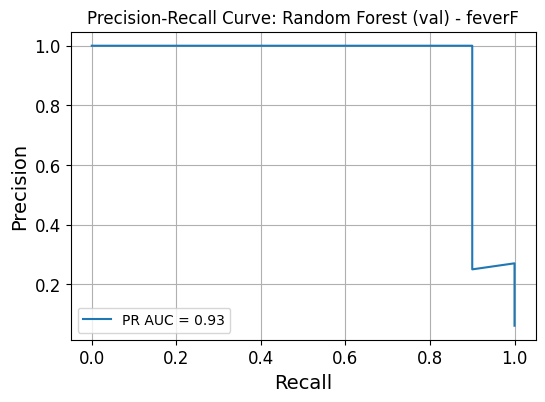

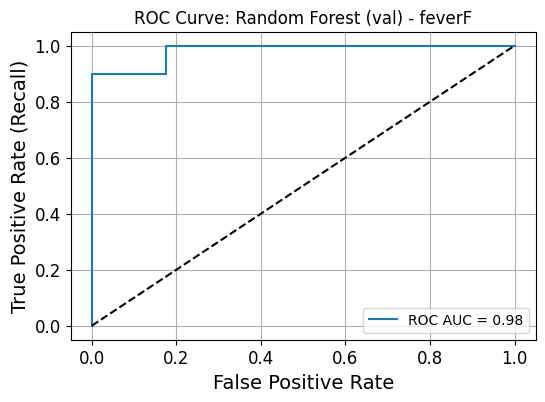


Threshold tuning for Random Forest (val) - feverF
Optimal Threshold: 0.41 | Max F1 Score: 0.9474

Random Forest (val, thresh) - feverF Evaluation with Threshold 0.41:
Accuracy:  0.994
Precision: 1.000
Recall:    0.900
F1 Score:  0.947


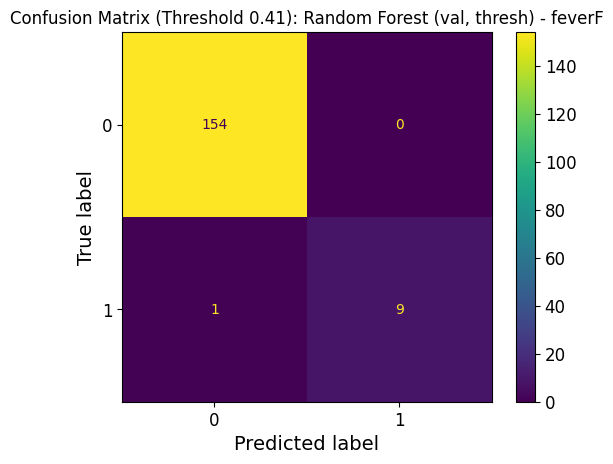

--------------------------------------------------------------------------------


Random Forest Classifier: feverM
Best Params for feverM: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}

Random Forest (val) - feverM Evaluation:
Accuracy:  0.970
Precision: 0.846
Recall:    0.786
F1 Score:  0.815
ROC AUC:   0.978


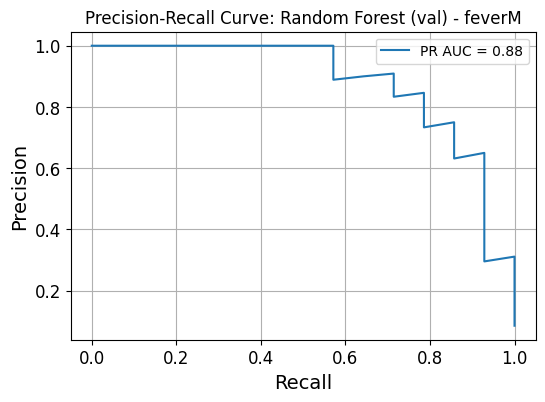

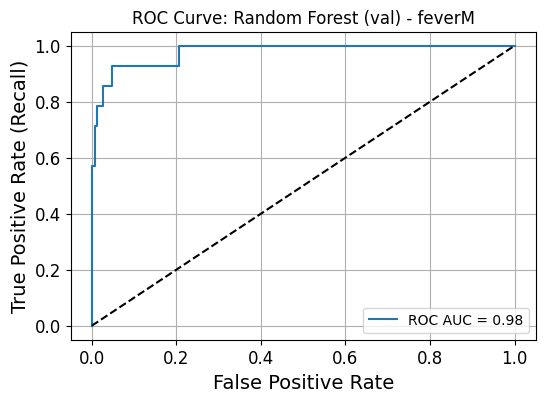


Threshold tuning for Random Forest (val) - feverM
Optimal Threshold: 0.44 | Max F1 Score: 0.8148

Random Forest (val, thresh) - feverM Evaluation with Threshold 0.44:
Accuracy:  0.970
Precision: 0.846
Recall:    0.786
F1 Score:  0.815


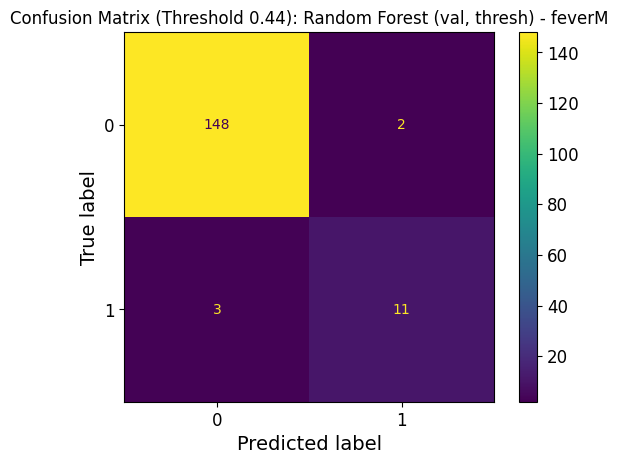

In [40]:
best_rf_feverF, thresh_rf_feverF, f1_rf_feverF = tune_and_evaluate_randomforest(
    X_train_clf, X_val_clf, y_train_feverF, y_val_feverF, "feverF"
)
print('-' * 80 + '\n')

best_rf_feverM, thresh_rf_feverM, f1_rf_feverM = tune_and_evaluate_randomforest(
    X_train_clf, X_val_clf, y_train_feverM, y_val_feverM, "feverM"
)

For `feverF`, Random Forest was the best performer, reaching a tuned validation F1-score of ≈0.947 (threshold ≈0.41) with perfect precision and high recall.
For `feverM`, it achieved an F1-score of ≈0.815 (threshold ≈0.44), slightly below Logistic Regression and SGD but still competitive, with ROC-AUC close to 0.978.

<br>

---
<br>

## **Validation-Based Classification Model Comparison and Predictive Features**

Permutation importance for the MLP Classifier (feverF) and feature importance for the Random Forest (feverM) are computed on the **validation set**, not on the test set. This avoids leaking information from the held-out test data into model interpretation: the test set is reserved exclusively for the final performance report.


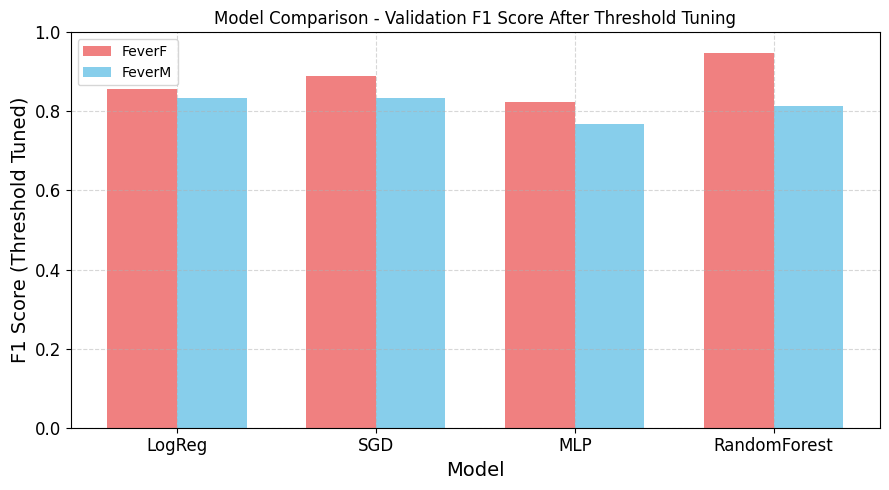

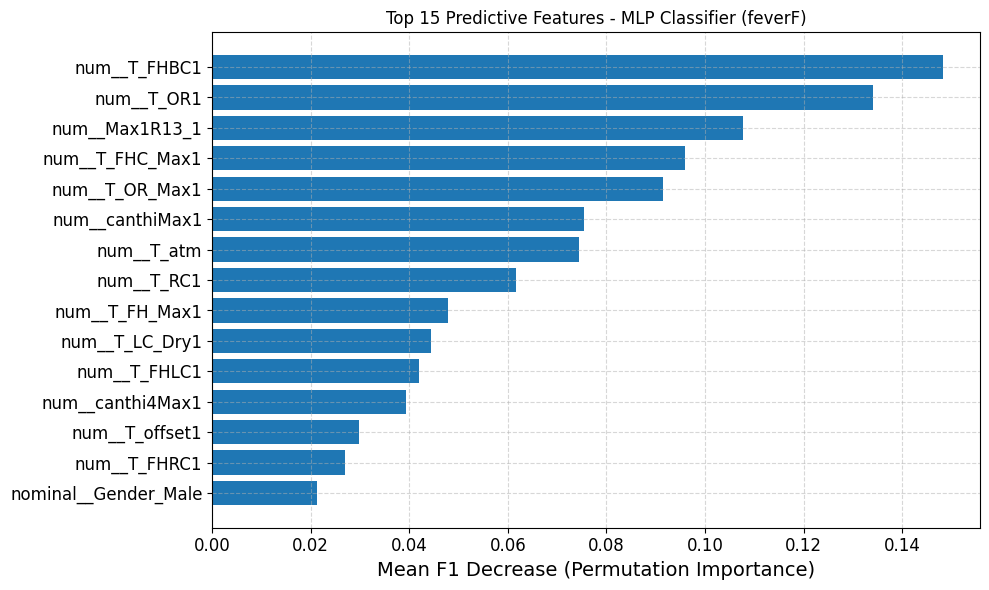

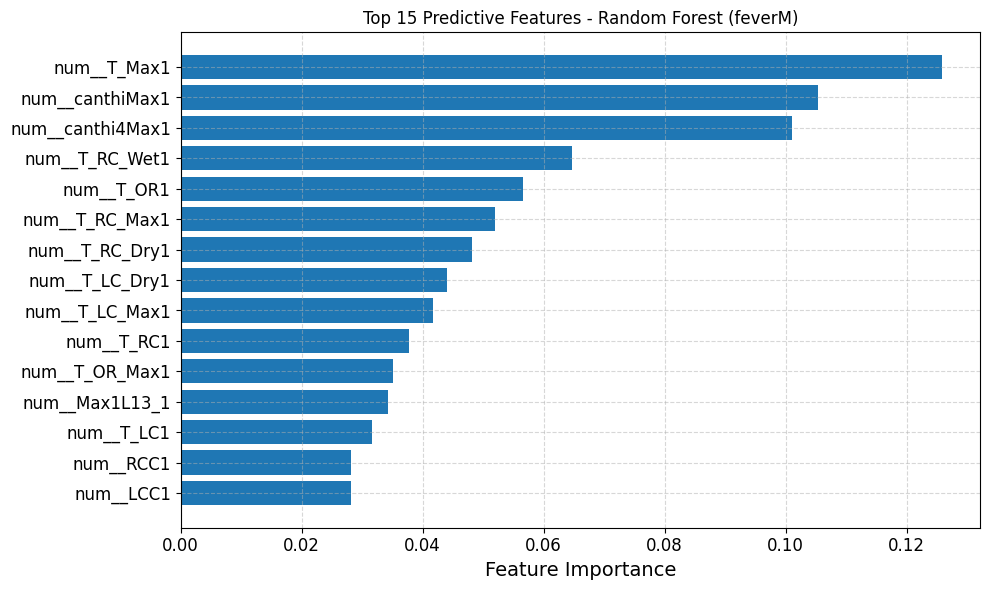

In [41]:
from sklearn.inspection import permutation_importance

# F1 scores storage
f1_scores_feverF = {
    "LogReg": f1_logreg_feverF,
    "SGD": f1_sgd_feverF,
    "MLP": f1_mlp_feverF,
    "RandomForest": f1_rf_feverF
}

f1_scores_feverM = {
    "LogReg": f1_logreg_feverM,
    "SGD": f1_sgd_feverM,
    "MLP": f1_mlp_feverM,
    "RandomForest": f1_rf_feverM
}

# F1 score comparison plot
models = list(f1_scores_feverF.keys())
x = np.arange(len(models))
width = 0.35

feverF_vals = [f1_scores_feverF[model] for model in models]
feverM_vals = [f1_scores_feverM[model] for model in models]

plt.figure(figsize=(9, 5))
plt.bar(x - width/2, feverF_vals, width, label='FeverF', color='lightcoral')
plt.bar(x + width/2, feverM_vals, width, label='FeverM', color='skyblue')

plt.xlabel("Model")
plt.ylabel("F1 Score (Threshold Tuned)")
plt.title("Model Comparison - Validation F1 Score After Threshold Tuning")
plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Get correct feature names
feature_names = preprocessor_scaled.get_feature_names_out()

# Permutation Importance Plot (MLP)
def plot_permutation_importance(model, X, y, feature_names, model_name, top_n=15):
    result = permutation_importance(
        model,
        X,
        y,
        scoring="f1",
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1
    )

    importances = result.importances_mean
    indices = np.argsort(importances)[::-1][:top_n]

    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[indices][::-1], importances[indices][::-1])
    plt.xlabel("Mean F1 Decrease (Permutation Importance)")
    plt.title(f"Top {top_n} Predictive Features - {model_name}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_permutation_importance(
    best_mlp_model_feverF,
    X_val_clf,
    y_val_feverF,
    feature_names,
    "MLP Classifier (feverF)"
)


# Feature Importance Plot (Random Forest)
def plot_feature_importance(model, feature_names, model_name, top_n=15):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]

    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[indices][::-1], importances[indices][::-1])
    plt.xlabel("Feature Importance")
    plt.title(f"Top {top_n} Predictive Features - {model_name}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_feature_importance(
    best_rf_feverM,
    feature_names,
    "Random Forest (feverM)"
)

For **feverF**, the **Random Forest Classifier** achieved the highest validation F1-score after threshold tuning (≈0.95), followed by SGD (≈0.89), Logistic Regression (≈0.86), and MLP (≈0.82).

For **feverM**, **Logistic Regression** and SGD obtained the strongest F1-scores (≈0.83), with Random Forest slightly behind (≈0.81) and MLP somewhat lower (≈0.77).

To better understand the decision-making of the models, feature importance analysis was conducted:

- **Permutation Importance (MLP Classifier – `feverF`)** showed that features such as `T_FHBC1`, `T_OR1`, `Max1R13_1`, `T_FHC_Max1`, `T_OR_Max1`, and `canthiMax1` produced the largest F1-score drops when shuffled, indicating high predictive value. Demographic attributes like `nominal__Gender_Male` and `nominal__Ethnicity_White` also had small but non-zero importance, possibly reflecting subtle physiological or imaging differences across subgroups.

- **Random Forest feature importance (`feverM`)** highlighted `T_Max1`, `canthiMax1`, and `canthi4Max1` as the top predictors, followed by several canthus- and mouth-related temperatures. This broadly aligns with the permutation results, with overlap on key regions such as the canthi, forehead, and mouth.

<br>

---
<br>

## **Final Evaluation on Held-Out Test Set**

<br>

### **Random Forest** as final model for feverF

Final Test Evaluation – Random Forest (feverF)

Random Forest (test, default 0.50) – feverF Evaluation:
Accuracy:  0.946
Precision: 0.562
Recall:    0.692
F1 Score:  0.621
ROC AUC:   0.972

Random Forest (test, tuned thresh = 0.41) – feverF Evaluation with Threshold 0.41:
Accuracy:  0.951
Precision: 0.579
Recall:    0.846
F1 Score:  0.688


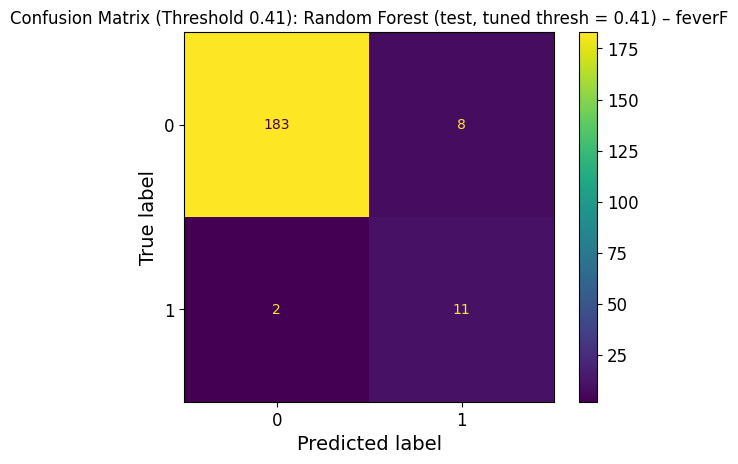

In [42]:
print("Final Test Evaluation – Random Forest (feverF)")

# Default threshold = 0.50 on test set
evaluate_model(
    best_rf_feverF,
    X_test_scaled,
    y_test_feverF,
    "Random Forest (test, default 0.50) – feverF"
)

# Tuned threshold from validation (thresh_rf_feverF)
evaluate_with_custom_threshold(
    best_rf_feverF,
    X_test_scaled,
    y_test_feverF,
    thresh_rf_feverF,
    f"Random Forest (test, tuned thresh = {thresh_rf_feverF:.2f}) – feverF"
)

#### **feverF** - Random Forest Model Evaluation Summary (Validation vs Test)
  
| Metric / Threshold | Validation (0.50) | Validation (0.41) | Test (0.50) | Test (0.41) |
|-------------------|-------------------|--------------------|--------------|--------------|
| **F1-score**      | 0.947             | 0.947              | 0.621        | **0.688**    |
| **Precision**     | 1.000              | 1.000               | 0.562        | 0.579        |
| **Recall**        | 0.900              | 0.900               | 0.692        | **0.846**    |
| **ROC AUC**       | 0.982             | –                  | 0.972        | –            |

The tuned threshold (0.41) maintains recall on the validation  set and **increases recall** on the test set, while keeping **precision stable**, allowing the model to capture more true fever cases, reducing false negatives (2), with only a modest rise in false positives (8). This sensitivity/recall trade-off is valuable in medical triage settings and aligns with Random Forest’s strong overall performance on infrared features.

The lower F1-score on the test set is largely due to the very small number of positive feverF cases (only 13). With such few samples, metrics like F1 and recall fluctuate sharply when just a few cases are misclassified, even though the model’s ROC-AUC and decision patterns remain consistent. This reflects normal statistical variability rather than poor generalisation.

ROC AUC is omitted (“–”) in the tuned-threshold rows because ROC AUC is **threshold-independent**: it is computed from the full probability curve rather than a single cut-off. Changing the classification threshold therefore does not change the ROC AUC value.


<br>

### **Logistic Regression** as final model for feverM

Final Test Evaluation – Logistic Regression (feverM)

Logistic Regression (test, default 0.50) – feverM Evaluation:
Accuracy:  0.966
Precision: 0.786
Recall:    0.957
F1 Score:  0.863
ROC AUC:   0.974

Logistic Regression (test, tuned thresh = 0.62) – feverM Evaluation with Threshold 0.62:
Accuracy:  0.956
Precision: 0.818
Recall:    0.783
F1 Score:  0.800


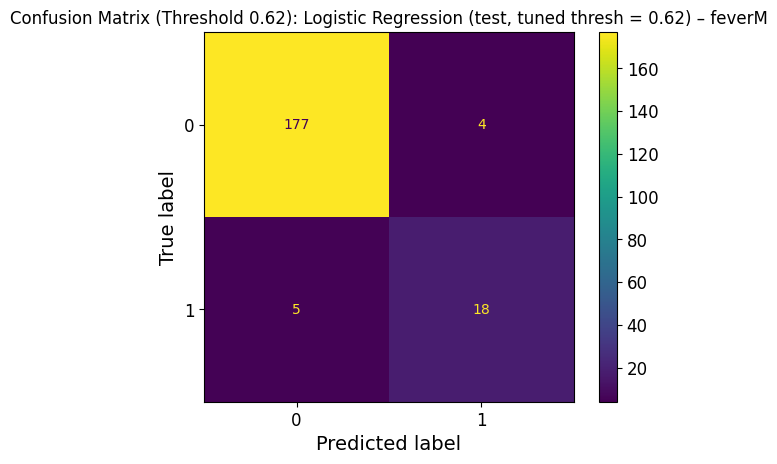

In [43]:
print("Final Test Evaluation – Logistic Regression (feverM)")

# Default threshold = 0.50 on test set
evaluate_model(
    best_logreg_feverM,
    X_test_scaled,
    y_test_feverM,
    "Logistic Regression (test, default 0.50) – feverM"
)

# Tuned threshold from validation (thresh_logreg_feverM)
evaluate_with_custom_threshold(
    best_logreg_feverM,
    X_test_scaled,
    y_test_feverM,
    thresh_logreg_feverM,
    f"Logistic Regression (test, tuned thresh = {thresh_logreg_feverM:.2f}) – feverM"
)

#### **feverM** - Logistic Regression Model Evaluation Summary (Validation vs Test)

| Metric / Threshold | Validation (0.50) | Validation (0.62) | Test (0.50) | Test (0.62) |
|-------------------|-------------------|--------------------|--------------|--------------|
| **F1-score**      | 0.706             | **0.833**          | **0.863**    | 0.800        |
| **Precision**     | 0.600             | **1.000**           | 0.786        | **0.818**    |
| **Recall**        | 0.857             | 0.714              | **0.957**    | 0.783        |
| **ROC AUC**       | 0.975             | –                  | 0.974        | –            |

The test-set results mirror validation behaviour: increasing the threshold (0.62) improves precision slightly but reduces recall and harms F1, which is less attractive when the goal is to keep a balanced error profile for monitor-mode measurements. The **default 0.50 threshold offers the best overall balance** between sensitivity and precision, while the tuned threshold may be preferable in precision-prioritising settings.

For feverM, the test set contains **23 positive cases**, still a relatively small number, so individual misclassifications also have a noticeable impact on F1 and recall even though ROC AUC remains high and stable.

ROC AUC is omitted (“–”) in the tuned-threshold rows because ROC AUC is **threshold-independent**: it is computed from the full probability curve rather than a single cut-off. Changing the classification threshold therefore does not change the ROC AUC value.
